# FIBERS Paper Analysis (Cross Validation)

In [19]:
import datetime
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from random import choice
from random import seed
from random import randrange
import collections
import statistics
import math
import numpy as numpy
import pandas as pd
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from lifelines import CoxPHFitter

In [20]:
import warnings
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)


Defining a function to delete variables with MAF = 0

In [21]:
def Remove_Empty_Variables (original_feature_matrix, label_name, duration_name):
    #Removing the label column to create a list of features
    feature_df = original_feature_matrix.drop(columns = [label_name, duration_name])
    
    #Creating a list of features 
    feature_list = []
    for column in feature_df:
        feature_list.append(str(column))
    feature_matrix_no_empty_variables = pd.DataFrame()
    
    #Creating a list of features with MAF = 0 to delete
    MAF_0_features = []
    
    for i in range (0, len(feature_list)):
        #If the MAF of the feature is less than the cutoff, it will be removed
        if feature_df[feature_list[i]].sum()/(2*len(feature_df.index)) == 0:
            MAF_0_features.append(feature_list[i])
    
    #Removing the features
    for j in range (0, len(MAF_0_features)):
        feature_list.remove(MAF_0_features[j])
    
    #Updating the feature matrix accordingly
    for k in range (0, len(feature_list)):
        feature_matrix_no_empty_variables[feature_list[k]] = feature_df[feature_list[k]]
    
    #Adding the class label to the feature matrix
    feature_matrix_no_empty_variables[label_name] = original_feature_matrix[label_name]
    feature_matrix_no_empty_variables[duration_name] = original_feature_matrix[duration_name]
    
    #Saving the feature list of nonempty features
    nonempty_feature_list = feature_list
    
    return feature_matrix_no_empty_variables, MAF_0_features, nonempty_feature_list

Defining a function to group features randomly, each feature can be in a number of groups up to a set max

In [22]:
def Random_Feature_Grouping(feature_matrix, label_name, duration_name, number_of_groups, min_features_per_group, 
                            max_number_of_groups_with_feature):
    
    #Removing the label column to create a list of features
    feature_df = feature_matrix.drop(columns = [label_name, duration_name])
    
    #Creating a list of features 
    feature_list = []
    for column in feature_df:
        feature_list.append(str(column))
    
    #Adding a random number of repeats of the features so that features can be in more than one group
    for w in range (0, len(feature_list)):
        repeats = randrange(max_number_of_groups_with_feature)
        for i in range (0, repeats):
            feature_list.append(feature_list[w])
    
    #Shuffling the feature list to enable random groups
    random.shuffle(feature_list)
    
    #Creating a dictionary of the groups
    feature_groups = {}
    
    #Assigns the minimum number of features to all the groups
    for x in range (0, min_features_per_group*number_of_groups, min_features_per_group):
        feature_groups[x/min_features_per_group] = feature_list[x:x+min_features_per_group]
    
    #Randomly distributes the remaining features across the set number of groups
    for y in range (min_features_per_group*number_of_groups, len(feature_list)):
        feature_groups[random.choice(list(feature_groups.keys()))].append(feature_list[y])
    
    #Removing duplicates of features in the same bin
    for z in range (0, len(feature_groups)):
        unique = []
        for a in range (0, len(feature_groups[z])):
            if feature_groups[z][a] not in unique:
                unique.append(feature_groups[z][a])
        feature_groups[z] = unique
    
    #Creating a dictionary with bin labels
    binned_feature_groups = {}
    for index in range (0, len(feature_groups)):
        binned_feature_groups["Bin " + str(index + 1)] = feature_groups[index]
    
    return feature_list, binned_feature_groups

Defining a function to create a feature matrix where each feature is a bin of features from the original feature matrix

In [23]:
def Grouped_Feature_Matrix(feature_matrix, label_name, duration_name, binned_feature_groups):
    
    #Creating an empty data frame for the feature matrix with bins
    bins_df = pd.DataFrame()
    
    #Creating a list of 0s, where the number of 0s is the number of instances in the original feature matrix
    zero_list = []
    for a in range (0, len(feature_matrix.index)):
        zero_list.append(0)
        
    #Creating a dummy data frame
    dummy_df = pd.DataFrame()
    dummy_df['Zeros'] = zero_list
    #The list and dummy data frame will be used for adding later
    
   #For each feature group/bin, the values of the amino acid in the bin will be summed to create a value for the bin 
    count = 0
    for key in binned_feature_groups:
        sum_column = dummy_df['Zeros']
        for j in range (0, len(binned_feature_groups[key])):
            sum_column = sum_column + feature_matrix[binned_feature_groups[key][j]]
        count = count + 1
        bins_df[key] = sum_column
    
    #Adding the class label to the data frame
    bins_df[label_name] = feature_matrix[label_name]
    bins_df[duration_name] = feature_matrix[duration_name]
    return bins_df

In [24]:
def LogRankTest_Feature_Importance(bin_feature_matrix, amino_acid_bins, label_name, duration_name, informative_cutoff):
    
    bin_scores = {}
    for Bin_name in amino_acid_bins.keys():
        df_0 = bin_feature_matrix.loc[bin_feature_matrix[Bin_name] == 0]
        df_1 = bin_feature_matrix.loc[bin_feature_matrix[Bin_name] > 0]
        
        durations_no = df_0[duration_name].to_list()
        event_observed_no = df_0[label_name].to_list()
        durations_mm = df_1[duration_name].to_list()
        event_observed_mm = df_1[label_name].to_list()
        
        
        if len(event_observed_no) > informative_cutoff*(len(event_observed_no) + len(event_observed_mm)) and len(event_observed_mm) > informative_cutoff*(len(event_observed_no) + len(event_observed_mm)):
            results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
            bin_scores[Bin_name] = results.test_statistic
        
        else:
            bin_scores[Bin_name] = 0
        
    for i in bin_scores.keys():
        if np.isnan(bin_scores[i]) == True:
            bin_scores[i] = 0
    
    return bin_scores

Defining a function to probabilitically select 2 parent bins based on their feature importance rank

Tournament Selection works in this case by choosing a random sample of the bins and choosing the best two scores

In [25]:
def Tournament_Selection_Parent_Bins(bin_scores):
    
    #Choosing a random sample of 5% of the bin population or if that would be too small, choosing a sample of 50%
    if round(0.05*len(bin_scores)) < 2:
        samplekeys = random.sample(bin_scores.keys(), round(0.5*len(bin_scores)))
    else: 
        samplekeys = random.sample(bin_scores.keys(), round(0.05*len(bin_scores)))
    
    sample = {}
    for key in samplekeys:
        sample[key] = bin_scores[key]
    
    #Sorting the bins from best score to worst score
    sorted_bin_scores = dict(sorted(sample.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    
    #Choosing the parent bins and adding them to a list of parent bins
    parent_bins = [sorted_bin_list[0], sorted_bin_list[1]]
    
    return parent_bins

Defining a function for crossover and mutation that creates n offspring based on crossover of selected parents 

It is the max number of bins (but not all the offspring will carry on, as the worst will be deleted in Step 2a next time)

In [26]:
def Crossover_and_Mutation(max_population_of_bins, elitism_parameter, feature_list, binned_feature_groups, bin_scores, 
                           crossover_probability, mutation_probability):

    #Creating a list for offspring
    offspring_list = []
    
    #Creating a number of offspring equal to the the number needed to replace the nonelites
    #Each pair of parents will produce two offspring
    for i in range (0, int((max_population_of_bins - (elitism_parameter*max_population_of_bins))/2)):
        #Choosing the two parents and gettings the list of features in each parent bin
        parent_bins = Tournament_Selection_Parent_Bins(bin_scores)
        parent1_features = binned_feature_groups[parent_bins[0]].copy()
        parent2_features = binned_feature_groups[parent_bins[1]].copy()

        #Creating two lists for the offspring bins
        offspring1 = []
        offspring2 = []
        
        #CROSSOVER
        #Each feature in the parent bin will crossover based on the given probability (uniform crossover)
        for j in range (0, len(parent1_features)):
            if crossover_probability > random.random():
                offspring2.append(parent1_features[j])
            else:
                offspring1.append(parent1_features[j])
        
        for k in range (0, len(parent2_features)):
            if crossover_probability > random.random():
                offspring1.append(parent2_features[k])
            else:
                offspring2.append(parent2_features[k])
        
        #Ensuring that each of the offspring is no more than twice the size of the other offspring
        while len(offspring1) > len(offspring2):
            switch = random.choice(offspring1)
            offspring1.remove(switch)
            offspring2.append(switch)
            
        while len(offspring2) > len(offspring1):
            switch = random.choice(offspring2)
            offspring2.remove(switch)
            offspring1.append(switch)
        
        
        #MUTATION
        #Mutation only occurs with a certain probability on each feature in the original feature space
        
        #Applying the mutation operation to the first offspring
        #Creating a probability for adding a feature that accounts for the ratio between the feature list and the size of the bin
        if len(offspring1) > 0 and len(offspring1) != len(feature_list):            
            mutation_addition_prob = (mutation_probability)*(len(offspring1))/((len(feature_list)-len(offspring1)))
        elif len(offspring1) == 0 and len(offspring1) != len(feature_list):
            mutation_addition_prob = mutation_probability
        elif len(offspring1) == len(feature_list):
            mutation_addition_prob = 0
        
        deleted_list = []
        #Deletion form of mutation
        for l in range (0, len(offspring1)):
            #Mutation (deletion) occurs on this feature with probability equal to the mutation parameter
            if mutation_probability > random.random():
                deleted_list.append(offspring1[l])
                
        
        for l in range (0, len(deleted_list)):
            offspring1.remove(deleted_list[l])
            
        #Creating a list of features outside the offspring
        features_not_in_offspring = [item for item in feature_list if item not in offspring1]
        
        #Addition form of mutation
        for l in range (0, len(features_not_in_offspring)):
            #Mutation (addiiton) occurs on this feature with probability proportional to the mutation parameter
            #The probability accounts for the ratio between the feature list and the size of the bin
            if mutation_addition_prob > random.random():
                    offspring1.append(features_not_in_offspring[l])
        
        #Applying the mutation operation to the second offspring
        #Creating a probability for adding a feature that accounts for the ratio between the feature list and the size of the bin
        if len(offspring2) > 0 and len(offspring2) != len(feature_list):            
            mutation_addition_prob = (mutation_probability)*(len(offspring2))/((len(feature_list)-len(offspring2)))
        elif len(offspring2) == 0 and len(offspring2) != len(feature_list):
            mutation_addition_prob = mutation_probability
        elif len(offspring2) == len(feature_list):
            mutation_addition_prob = 0
        
        deleted_list = []
        #Deletion form of mutation
        for l in range (0, len(offspring2)):
            #Mutation (deletion) occurs on this feature with probability equal to the mutation parameter
            if mutation_probability > random.random():
                deleted_list.append(offspring2[l])
        
        for l in range (0, len(deleted_list)):
            offspring2.remove(deleted_list[l])
        
        #Creating a list of features outside the offspring
        features_not_in_offspring = [item for item in feature_list if item not in offspring2]
        
        #Addition form of mutation
        for l in range (0, len(features_not_in_offspring)):
            #Mutation (addiiton) occurs on this feature with probability proportional to the mutation parameter
            #The probability accounts for the ratio between the feature list and the size of the bin
            if mutation_addition_prob > random.random():
                    offspring2.append(features_not_in_offspring[l])
            
        #CLEANUP
        #Deleting any repeats of an amino acid in a bin
        #Removing duplicates of features in the same bin that may arise due to crossover
        unique = []
        for a in range (0, len(offspring1)):
            if offspring1[a] not in unique:
                unique.append(offspring1[a])
        
        #Adding random features from outside the bin to replace the deleted features in the bin
        replace_number = len(offspring1) - len(unique)
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in offspring1]
        offspring1 = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        offspring1.extend(replacements)
        
        unique = []
        for a in range (0, len(offspring2)):
            if offspring2[a] not in unique:
                unique.append(offspring2[a])
        
        #Adding random features from outside the bin to replace the deleted features in the bin
        replace_number = len(offspring2) - len(unique)
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in offspring2]
        offspring2 = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        offspring2.extend(replacements)
        
        #Adding the new offspring to the list of feature bins
        offspring_list.append(offspring1)
        offspring_list.append(offspring2)
        
   
    return offspring_list

In [27]:
def Create_Next_Generation(binned_feature_groups, bin_scores, max_population_of_bins, elitism_parameter, offspring_list):
    
    #Sorting the bins from best score to worst score
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
        
    #Determining the number of elite bins
    number_of_elite_bins = round(max_population_of_bins*elitism_parameter)
    elites = []
    #Adding the elites to a list of elite feature bins
    for a in range (0, number_of_elite_bins):
        elites.append(binned_feature_groups[sorted_bin_list[a]])
    
    #Creating a list of feature bins (without labels because those will be changed as things get deleted and added)
    feature_bin_list = elites.copy()
    
    #Adding the offspring to the feature bin list
    feature_bin_list.extend(offspring_list)
    return feature_bin_list

Defining a function to recreate the feature matrix (add up values of amino a cids from original dataset)

In [28]:
def Regroup_Feature_Matrix(feature_list, feature_matrix, label_name, duration_name, feature_bin_list):
    
    
    #First deleting any bins that are empty
    #Creating a list of bins to delete
    bins_to_delete = []
    for i in feature_bin_list:
        if not i:
            bins_to_delete.append(i)
    for i in bins_to_delete:
        feature_bin_list.remove(i)
    
    #The length of the bin will be equal to the average length of nonempty bins in the population
    bin_lengths = []
    for i in feature_bin_list:
        if len(i) > 0:
            bin_lengths.append(len(i))      
    replacement_length = round(statistics.mean(bin_lengths))
    
    #Replacing each deleted bin with a bin with random features
    for i in range (0, len(bins_to_delete)):
        replacement = random.sample(feature_list, replacement_length)
        feature_bin_list.append(replacement)

    #Checking each pair of bins, if the bins are duplicates then one of the copies will be deleted
    seen = set()
    unique = []
    for x in feature_bin_list:
        srtd = tuple(sorted(x))
        if srtd not in seen:
            unique.append(x)
            seen.add(srtd)
    
    #Replacing each deleted bin with a bin with random features
    replacement_number = len(feature_bin_list) - len(unique)
    feature_bin_list = unique.copy()
    
    for i in feature_bin_list:
        if len(i) > 0:
            bin_lengths.append(len(i))      
    replacement_length = round(statistics.mean(bin_lengths))
    
    for i in range(0, replacement_number):
        replacement = random.sample(feature_list, replacement_length)
        feature_bin_list.append(replacement)
    
    
    #Deleting duplicate features in the same bin and replacing them with random features
    for Bin in range (0, len(feature_bin_list)):
        unique = []
        for a in range (0, len(feature_bin_list[Bin])):
            if feature_bin_list[Bin][a] not in unique:
                unique.append(feature_bin_list[Bin][a])
    
        replace_number = len(feature_bin_list[Bin]) - len(unique)
        
        features_not_in_offspring = []
        features_not_in_offspring = [item for item in feature_list if item not in feature_bin_list[Bin]]
        
        bin_replacement = unique.copy()
        if len(features_not_in_offspring) > replace_number:
            replacements = random.sample(features_not_in_offspring, replace_number)
        else:
            replacements = features_not_in_offspring.copy()
        bin_replacement.extend(replacements)
        
        feature_bin_list[Bin] = bin_replacement.copy()
    
    #Creating an empty data frame for the feature matrix with bins
    bins_df = pd.DataFrame()
    
    #Creating a list of 0s, where the number of 0s is the number of instances in the original feature matrix
    zero_list = []
    for a in range (0, len(feature_matrix.index)):
        zero_list.append(0)
        
    #Creating a dummy data frame
    dummy_df = pd.DataFrame()
    dummy_df['Zeros'] = zero_list
    #The list and dummy data frame will be used for adding later
    
   #For each feature group/bin, the values of the amino acid in the bin will be summed to create a value for the bin
   #This will be used to create a a feature matrix for the bins and a dictionary of binned feature groups
    count = 0
    binned_feature_groups = {}
    
    for i in range (0, len(feature_bin_list)):
        sum_column = dummy_df['Zeros']
        for j in range (0, len(feature_bin_list[i])):
            sum_column = sum_column + feature_matrix[feature_bin_list[i][j]]
        count = count + 1
        bins_df["Bin " + str(count)] = sum_column
        binned_feature_groups["Bin " + str(count)] = feature_bin_list[i]
    
    #Adding the class label to the data frame
    bins_df[label_name] = feature_matrix[label_name]
    bins_df[duration_name] = feature_matrix[duration_name]
    return bins_df, binned_feature_groups

In [29]:
def SurvivalRARE (given_starting_point, amino_acid_start_point, amino_acid_bins_start_point, iterations, original_feature_matrix, 
          label_name, duration_name, set_number_of_bins, min_features_per_group, max_number_of_groups_with_feature, informative_cutoff,
          crossover_probability, mutation_probability, elitism_parameter):

    #Step 0: Deleting Empty Features (MAF = 0)
    feature_matrix_no_empty_variables, MAF_0_features, nonempty_feature_list = Remove_Empty_Variables(original_feature_matrix, 
                                                                                                      label_name, duration_name)

    #Step 1: Initialize Population of Candidate Bins 
    #Initialize Feature Groups
    
    #If there is a starting point, use that for the amino acid list and the amino acid bins list
    if given_starting_point == True:
        amino_acid_bins = amino_acid_bins_start_point.copy()
        amino_acids = amino_acid_start_point.copy()
        
        features_to_remove = [item for item in amino_acids if item not in nonempty_feature_list]
        for feature in features_to_remove:
            amino_acids.remove(feature)
                
        bin_names = amino_acid_bins.keys()
        for bin_name in bin_names:
            for feature in features_to_remove:
                if feature in amino_acid_bins[bin_name]:
                    amino_acid_bins[bin_name].remove(feature)
                    
    #Otherwise randomly initialize the bins
    elif given_starting_point == False:
        amino_acids, amino_acid_bins = Random_Feature_Grouping(feature_matrix_no_empty_variables, label_name, duration_name,
                                                               set_number_of_bins, min_features_per_group, 
                                                               max_number_of_groups_with_feature)
    
    #Create Initial Binned Feature Matrix
    bin_feature_matrix = Grouped_Feature_Matrix(feature_matrix_no_empty_variables, label_name, duration_name, amino_acid_bins)
    
    #Step 2: Genetic Algorithm with Feature Scoring (repeated for a given number of iterations)
    for i in range (0, iterations):
        
        #Step 2a: Feature Importance Scoring and Bin Deletion
        
        amino_acid_bin_scores = LogRankTest_Feature_Importance(bin_feature_matrix, amino_acid_bins, label_name, duration_name, informative_cutoff)

        #Step 2b: Genetic Algorithm 
        #Creating the offspring bins through crossover and mutation
        offspring_bins = Crossover_and_Mutation(set_number_of_bins, elitism_parameter, amino_acids, amino_acid_bins, amino_acid_bin_scores,
                                                crossover_probability, mutation_probability)
        
        #Creating the new generation by preserving some elites and adding the offspring
        feature_bin_list = Create_Next_Generation(amino_acid_bins, amino_acid_bin_scores, set_number_of_bins, 
                                                  elitism_parameter, offspring_bins)
        
        bin_feature_matrix, amino_acid_bins = Regroup_Feature_Matrix(amino_acids, original_feature_matrix, label_name, duration_name, feature_bin_list)
    
    #Creating the final amino acid bin scores
    amino_acid_bin_scores = LogRankTest_Feature_Importance(bin_feature_matrix, amino_acid_bins, label_name, duration_name, informative_cutoff)
 
    
    return bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features

In [30]:
def Top_Bin_Summary(original_feature_matrix, label_name, duration_name, bin_feature_matrix, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(durations_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(durations_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')
    plt.show()

In [31]:
def Top_Bin_Summary_Test(original_feature_matrix, label_name, duration_name, amino_acids, bins, bin_scores):
    
    #Ordering the bin scores from best to worst
    sorted_bin_scores = dict(sorted(bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    
    topbin = sorted_bin_list[0]
    
    feature_bin_list = list(bins.values())
    bin_feature_matrix, amino_acid_bins = Regroup_Feature_Matrix(amino_acids, original_feature_matrix, label_name, duration_name, feature_bin_list)
    
    df_0 = bin_feature_matrix.loc[bin_feature_matrix[topbin] == 0]
    df_1 = bin_feature_matrix.loc[bin_feature_matrix[topbin] > 0]
        
    durations_no = df_0[duration_name].to_list()        
    event_observed_no = df_0[label_name].to_list()
    durations_mm = df_1[duration_name].to_list()
    event_observed_mm = df_1[label_name].to_list()
        
    results = logrank_test(durations_no, durations_mm, event_observed_A=event_observed_no, event_observed_B=event_observed_mm)
    
    print("Bin of Amino Acid Positions:")
    print(bins[topbin])
    print("---")
    print("Number of Instances with No Mismatches in Bin:")
    print(len(event_observed_no))
    print("Number of Instances with Mismatch(es) in Bin:")
    print(len(event_observed_mm))
    print("---")
    print("p-value from Log Rank Test:")
    print(results.p_value)
    results.print_summary()
    kmf1 = KaplanMeierFitter() 

    ## fit the model for 1st cohort
    kmf1.fit(durations_no, event_observed_no, label='No Mismatches in Bin')
    a1 = kmf1.plot()
    a1.set_ylabel('Survival Probability')

    ## fit the model for 2nd cohort
    kmf1.fit(durations_mm, event_observed_mm, label='Mismatch(es) in Bin')
    kmf1.plot(ax=a1)
    a1.set_xlabel('Years After Transplant')
    plt.show()

In [32]:
data = pd.read_csv('data/Imp1.csv')

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/3429140423.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/Imp1.csv')


In [33]:
indices = list(data.index.values)
random.seed(0)
test_indices = []
def partition (list_in, n):
    random.shuffle(list_in)
    for i in range(n):
        test_indices.append(list_in[i::n])

In [34]:
partition(indices, 10)

In [50]:
def run_validation(x):
    print("Cross Validation", x+1)
    train_index = list()
    for i in range(10):
        if i != x:
             train_index += test_indices[i]
    test_index = test_indices[x]
    training_data, test_data = data.loc[train_index], data.loc[test_index]
    training_data.reset_index(drop=True, inplace=True)
    test_data.reset_index(drop=True, inplace=True)
    grf_dataT = training_data[['graftyrs', 'grf_fail', 'A1', 'A10', 'A100', 'A101', 'A102', 'A103', 'A104', 'A105', 'A106', 'A107', 'A108', 'A109', 'A11', 'A110', 'A111', 'A112', 'A113', 'A114', 'A115', 'A116', 'A117', 'A118', 'A119', 'A12', 'A120', 'A121', 'A122', 'A123', 'A124', 'A125', 'A126', 'A127', 'A128', 'A129', 'A13', 'A130', 'A131', 'A132', 'A133', 'A134', 'A135', 'A136', 'A137', 'A138', 'A139', 'A14', 'A140', 'A141', 'A142', 'A143', 'A144', 'A145', 'A146', 'A147', 'A148', 'A149', 'A15', 'A150', 'A151', 'A152', 'A153', 'A154', 'A155', 'A156', 'A157', 'A158', 'A159', 'A16', 'A160', 'A161', 'A162', 'A163', 'A164', 'A165', 'A166', 'A167', 'A168', 'A169', 'A17', 'A170', 'A171', 'A172', 'A173', 'A174', 'A175', 'A176', 'A177', 'A178', 'A179', 'A18', 'A180', 'A181', 'A182', 'A183', 'A184', 'A185', 'A186', 'A187', 'A188', 'A189', 'A19', 'A190', 'A191', 'A192', 'A193', 'A194', 'A195', 'A196', 'A197', 'A198', 'A199', 'A2', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A3', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A4', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A5', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A6', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A7', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A8', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A9', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99', 'B1', 'B10', 'B100', 'B101', 'B102', 'B103', 'B104', 'B105', 'B106', 'B107', 'B108', 'B109', 'B11', 'B110', 'B111', 'B112', 'B113', 'B114', 'B115', 'B116', 'B117', 'B118', 'B119', 'B12', 'B120', 'B121', 'B122', 'B123', 'B124', 'B125', 'B126', 'B127', 'B128', 'B129', 'B13', 'B130', 'B131', 'B132', 'B133', 'B134', 'B135', 'B136', 'B137', 'B138', 'B139', 'B14', 'B140', 'B141', 'B142', 'B143', 'B144', 'B145', 'B146', 'B147', 'B148', 'B149', 'B15', 'B150', 'B151', 'B152', 'B153', 'B154', 'B155', 'B156', 'B157', 'B158', 'B159', 'B16', 'B160', 'B161', 'B162', 'B163', 'B164', 'B165', 'B166', 'B167', 'B168', 'B169', 'B17', 'B170', 'B171', 'B172', 'B173', 'B174', 'B175', 'B176', 'B177', 'B178', 'B179', 'B18', 'B180', 'B181', 'B182', 'B183', 'B184', 'B185', 'B186', 'B187', 'B188', 'B189', 'B19', 'B190', 'B191', 'B192', 'B193', 'B194', 'B2', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B3', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B4', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B5', 'B50', 'B51', 'B52', 'B53', 'B54', 'B55', 'B56', 'B57', 'B58', 'B59', 'B6', 'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B69', 'B7', 'B70', 'B71', 'B72', 'B73', 'B74', 'B75', 'B76', 'B77', 'B78', 'B79', 'B8', 'B80', 'B81', 'B82', 'B83', 'B84', 'B85', 'B86', 'B87', 'B88', 'B89', 'B9', 'B90', 'B91', 'B92', 'B93', 'B94', 'B95', 'B96', 'B97', 'B98', 'B99', 'C1', 'C10', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C11', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C12', 'C120', 'C121', 'C122', 'C123', 'C124', 'C125', 'C126', 'C127', 'C128', 'C129', 'C13', 'C130', 'C131', 'C132', 'C133', 'C134', 'C135', 'C136', 'C137', 'C138', 'C139', 'C14', 'C140', 'C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C147', 'C148', 'C149', 'C15', 'C150', 'C151', 'C152', 'C153', 'C154', 'C155', 'C156', 'C157', 'C158', 'C159', 'C16', 'C160', 'C161', 'C162', 'C163', 'C164', 'C165', 'C166', 'C167', 'C168', 'C169', 'C17', 'C170', 'C171', 'C172', 'C173', 'C174', 'C175', 'C176', 'C177', 'C178', 'C179', 'C18', 'C180', 'C181', 'C182', 'C183', 'C184', 'C185', 'C186', 'C187', 'C188', 'C189', 'C19', 'C190', 'C191', 'C192', 'C193', 'C194', 'C195', 'C196', 'C197', 'C198', 'C199', 'C2', 'C20', 'C200', 'C201', 'C202', 'C203', 'C204', 'C205', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C4', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C5', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C6', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C7', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C8', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C9', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'DQB11', 'DQB110', 'DQB111', 'DQB112', 'DQB113', 'DQB114', 'DQB115', 'DQB116', 'DQB117', 'DQB118', 'DQB119', 'DQB12', 'DQB120', 'DQB121', 'DQB122', 'DQB123', 'DQB124', 'DQB125', 'DQB126', 'DQB127', 'DQB128', 'DQB129', 'DQB13', 'DQB130', 'DQB131', 'DQB132', 'DQB133', 'DQB134', 'DQB135', 'DQB136', 'DQB137', 'DQB138', 'DQB139', 'DQB14', 'DQB140', 'DQB141', 'DQB142', 'DQB143', 'DQB144', 'DQB145', 'DQB146', 'DQB147', 'DQB148', 'DQB149', 'DQB15', 'DQB150', 'DQB151', 'DQB152', 'DQB153', 'DQB154', 'DQB155', 'DQB156', 'DQB157', 'DQB158', 'DQB159', 'DQB16', 'DQB160', 'DQB161', 'DQB162', 'DQB163', 'DQB164', 'DQB165', 'DQB166', 'DQB167', 'DQB168', 'DQB169', 'DQB17', 'DQB170', 'DQB171', 'DQB172', 'DQB173', 'DQB174', 'DQB175', 'DQB176', 'DQB177', 'DQB178', 'DQB179', 'DQB18', 'DQB180', 'DQB181', 'DQB182', 'DQB183', 'DQB184', 'DQB185', 'DQB186', 'DQB187', 'DQB188', 'DQB189', 'DQB19', 'DQB190', 'DQB191', 'DQB192', 'DQB193', 'DQB194', 'DRB11', 'DRB110', 'DRB111', 'DRB112', 'DRB113', 'DRB114', 'DRB115', 'DRB116', 'DRB117', 'DRB118', 'DRB119', 'DRB12', 'DRB120', 'DRB121', 'DRB122', 'DRB123', 'DRB124', 'DRB125', 'DRB126', 'DRB127', 'DRB128', 'DRB129', 'DRB13', 'DRB130', 'DRB131', 'DRB132', 'DRB133', 'DRB134', 'DRB135', 'DRB136', 'DRB137', 'DRB138', 'DRB139', 'DRB14', 'DRB140', 'DRB141', 'DRB142', 'DRB143', 'DRB144', 'DRB145', 'DRB146', 'DRB147', 'DRB148', 'DRB149', 'DRB15', 'DRB150', 'DRB151', 'DRB152', 'DRB153', 'DRB154', 'DRB155', 'DRB156', 'DRB157', 'DRB158', 'DRB159', 'DRB16', 'DRB160', 'DRB161', 'DRB162', 'DRB163', 'DRB164', 'DRB165', 'DRB166', 'DRB167', 'DRB168', 'DRB169', 'DRB17', 'DRB170', 'DRB171', 'DRB172', 'DRB173', 'DRB174', 'DRB175', 'DRB176', 'DRB177', 'DRB178', 'DRB179', 'DRB18', 'DRB180', 'DRB181', 'DRB182', 'DRB183', 'DRB184', 'DRB185', 'DRB186', 'DRB187', 'DRB188', 'DRB189', 'DRB19', 'DRB190', 'DRB191', 'DRB192', 'DRB193', 'DRB194']]
    test_grf_dataT = test_data[['graftyrs', 'grf_fail', 'A1', 'A10', 'A100', 'A101', 'A102', 'A103', 'A104', 'A105', 'A106', 'A107', 'A108', 'A109', 'A11', 'A110', 'A111', 'A112', 'A113', 'A114', 'A115', 'A116', 'A117', 'A118', 'A119', 'A12', 'A120', 'A121', 'A122', 'A123', 'A124', 'A125', 'A126', 'A127', 'A128', 'A129', 'A13', 'A130', 'A131', 'A132', 'A133', 'A134', 'A135', 'A136', 'A137', 'A138', 'A139', 'A14', 'A140', 'A141', 'A142', 'A143', 'A144', 'A145', 'A146', 'A147', 'A148', 'A149', 'A15', 'A150', 'A151', 'A152', 'A153', 'A154', 'A155', 'A156', 'A157', 'A158', 'A159', 'A16', 'A160', 'A161', 'A162', 'A163', 'A164', 'A165', 'A166', 'A167', 'A168', 'A169', 'A17', 'A170', 'A171', 'A172', 'A173', 'A174', 'A175', 'A176', 'A177', 'A178', 'A179', 'A18', 'A180', 'A181', 'A182', 'A183', 'A184', 'A185', 'A186', 'A187', 'A188', 'A189', 'A19', 'A190', 'A191', 'A192', 'A193', 'A194', 'A195', 'A196', 'A197', 'A198', 'A199', 'A2', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27', 'A28', 'A29', 'A3', 'A30', 'A31', 'A32', 'A33', 'A34', 'A35', 'A36', 'A37', 'A38', 'A39', 'A4', 'A40', 'A41', 'A42', 'A43', 'A44', 'A45', 'A46', 'A47', 'A48', 'A49', 'A5', 'A50', 'A51', 'A52', 'A53', 'A54', 'A55', 'A56', 'A57', 'A58', 'A59', 'A6', 'A60', 'A61', 'A62', 'A63', 'A64', 'A65', 'A66', 'A67', 'A68', 'A69', 'A7', 'A70', 'A71', 'A72', 'A73', 'A74', 'A75', 'A76', 'A77', 'A78', 'A79', 'A8', 'A80', 'A81', 'A82', 'A83', 'A84', 'A85', 'A86', 'A87', 'A88', 'A89', 'A9', 'A90', 'A91', 'A92', 'A93', 'A94', 'A95', 'A96', 'A97', 'A98', 'A99', 'B1', 'B10', 'B100', 'B101', 'B102', 'B103', 'B104', 'B105', 'B106', 'B107', 'B108', 'B109', 'B11', 'B110', 'B111', 'B112', 'B113', 'B114', 'B115', 'B116', 'B117', 'B118', 'B119', 'B12', 'B120', 'B121', 'B122', 'B123', 'B124', 'B125', 'B126', 'B127', 'B128', 'B129', 'B13', 'B130', 'B131', 'B132', 'B133', 'B134', 'B135', 'B136', 'B137', 'B138', 'B139', 'B14', 'B140', 'B141', 'B142', 'B143', 'B144', 'B145', 'B146', 'B147', 'B148', 'B149', 'B15', 'B150', 'B151', 'B152', 'B153', 'B154', 'B155', 'B156', 'B157', 'B158', 'B159', 'B16', 'B160', 'B161', 'B162', 'B163', 'B164', 'B165', 'B166', 'B167', 'B168', 'B169', 'B17', 'B170', 'B171', 'B172', 'B173', 'B174', 'B175', 'B176', 'B177', 'B178', 'B179', 'B18', 'B180', 'B181', 'B182', 'B183', 'B184', 'B185', 'B186', 'B187', 'B188', 'B189', 'B19', 'B190', 'B191', 'B192', 'B193', 'B194', 'B2', 'B20', 'B21', 'B22', 'B23', 'B24', 'B25', 'B26', 'B27', 'B28', 'B29', 'B3', 'B30', 'B31', 'B32', 'B33', 'B34', 'B35', 'B36', 'B37', 'B38', 'B39', 'B4', 'B40', 'B41', 'B42', 'B43', 'B44', 'B45', 'B46', 'B47', 'B48', 'B49', 'B5', 'B50', 'B51', 'B52', 'B53', 'B54', 'B55', 'B56', 'B57', 'B58', 'B59', 'B6', 'B60', 'B61', 'B62', 'B63', 'B64', 'B65', 'B66', 'B67', 'B68', 'B69', 'B7', 'B70', 'B71', 'B72', 'B73', 'B74', 'B75', 'B76', 'B77', 'B78', 'B79', 'B8', 'B80', 'B81', 'B82', 'B83', 'B84', 'B85', 'B86', 'B87', 'B88', 'B89', 'B9', 'B90', 'B91', 'B92', 'B93', 'B94', 'B95', 'B96', 'B97', 'B98', 'B99', 'C1', 'C10', 'C100', 'C101', 'C102', 'C103', 'C104', 'C105', 'C106', 'C107', 'C108', 'C109', 'C11', 'C110', 'C111', 'C112', 'C113', 'C114', 'C115', 'C116', 'C117', 'C118', 'C119', 'C12', 'C120', 'C121', 'C122', 'C123', 'C124', 'C125', 'C126', 'C127', 'C128', 'C129', 'C13', 'C130', 'C131', 'C132', 'C133', 'C134', 'C135', 'C136', 'C137', 'C138', 'C139', 'C14', 'C140', 'C141', 'C142', 'C143', 'C144', 'C145', 'C146', 'C147', 'C148', 'C149', 'C15', 'C150', 'C151', 'C152', 'C153', 'C154', 'C155', 'C156', 'C157', 'C158', 'C159', 'C16', 'C160', 'C161', 'C162', 'C163', 'C164', 'C165', 'C166', 'C167', 'C168', 'C169', 'C17', 'C170', 'C171', 'C172', 'C173', 'C174', 'C175', 'C176', 'C177', 'C178', 'C179', 'C18', 'C180', 'C181', 'C182', 'C183', 'C184', 'C185', 'C186', 'C187', 'C188', 'C189', 'C19', 'C190', 'C191', 'C192', 'C193', 'C194', 'C195', 'C196', 'C197', 'C198', 'C199', 'C2', 'C20', 'C200', 'C201', 'C202', 'C203', 'C204', 'C205', 'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C3', 'C30', 'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C4', 'C40', 'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C5', 'C50', 'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C6', 'C60', 'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C7', 'C70', 'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C8', 'C80', 'C81', 'C82', 'C83', 'C84', 'C85', 'C86', 'C87', 'C88', 'C89', 'C9', 'C90', 'C91', 'C92', 'C93', 'C94', 'C95', 'C96', 'C97', 'C98', 'C99', 'DQB11', 'DQB110', 'DQB111', 'DQB112', 'DQB113', 'DQB114', 'DQB115', 'DQB116', 'DQB117', 'DQB118', 'DQB119', 'DQB12', 'DQB120', 'DQB121', 'DQB122', 'DQB123', 'DQB124', 'DQB125', 'DQB126', 'DQB127', 'DQB128', 'DQB129', 'DQB13', 'DQB130', 'DQB131', 'DQB132', 'DQB133', 'DQB134', 'DQB135', 'DQB136', 'DQB137', 'DQB138', 'DQB139', 'DQB14', 'DQB140', 'DQB141', 'DQB142', 'DQB143', 'DQB144', 'DQB145', 'DQB146', 'DQB147', 'DQB148', 'DQB149', 'DQB15', 'DQB150', 'DQB151', 'DQB152', 'DQB153', 'DQB154', 'DQB155', 'DQB156', 'DQB157', 'DQB158', 'DQB159', 'DQB16', 'DQB160', 'DQB161', 'DQB162', 'DQB163', 'DQB164', 'DQB165', 'DQB166', 'DQB167', 'DQB168', 'DQB169', 'DQB17', 'DQB170', 'DQB171', 'DQB172', 'DQB173', 'DQB174', 'DQB175', 'DQB176', 'DQB177', 'DQB178', 'DQB179', 'DQB18', 'DQB180', 'DQB181', 'DQB182', 'DQB183', 'DQB184', 'DQB185', 'DQB186', 'DQB187', 'DQB188', 'DQB189', 'DQB19', 'DQB190', 'DQB191', 'DQB192', 'DQB193', 'DQB194', 'DRB11', 'DRB110', 'DRB111', 'DRB112', 'DRB113', 'DRB114', 'DRB115', 'DRB116', 'DRB117', 'DRB118', 'DRB119', 'DRB12', 'DRB120', 'DRB121', 'DRB122', 'DRB123', 'DRB124', 'DRB125', 'DRB126', 'DRB127', 'DRB128', 'DRB129', 'DRB13', 'DRB130', 'DRB131', 'DRB132', 'DRB133', 'DRB134', 'DRB135', 'DRB136', 'DRB137', 'DRB138', 'DRB139', 'DRB14', 'DRB140', 'DRB141', 'DRB142', 'DRB143', 'DRB144', 'DRB145', 'DRB146', 'DRB147', 'DRB148', 'DRB149', 'DRB15', 'DRB150', 'DRB151', 'DRB152', 'DRB153', 'DRB154', 'DRB155', 'DRB156', 'DRB157', 'DRB158', 'DRB159', 'DRB16', 'DRB160', 'DRB161', 'DRB162', 'DRB163', 'DRB164', 'DRB165', 'DRB166', 'DRB167', 'DRB168', 'DRB169', 'DRB17', 'DRB170', 'DRB171', 'DRB172', 'DRB173', 'DRB174', 'DRB175', 'DRB176', 'DRB177', 'DRB178', 'DRB179', 'DRB18', 'DRB180', 'DRB181', 'DRB182', 'DRB183', 'DRB184', 'DRB185', 'DRB186', 'DRB187', 'DRB188', 'DRB189', 'DRB19', 'DRB190', 'DRB191', 'DRB192', 'DRB193', 'DRB194']]
    start_time = datetime.datetime.now()
    bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores, MAF_0_features = SurvivalRARE(False, False, False, 500, grf_dataT,'grf_fail', 'graftyrs', 50, 2, 2, 0.2, 0.8, 0.4, 0.8)
    run_time = datetime.datetime.now() - start_time
    print("CV", x, "Runtime", run_time)
    Top_Bin_Summary(grf_dataT, 'grf_fail', 'graftyrs', bin_feature_matrix, amino_acid_bins, amino_acid_bin_scores)
    Top_Bin_Summary_Test(test_grf_dataT, 'grf_fail', 'graftyrs', MAF_0_features, amino_acid_bins, amino_acid_bin_scores)
    sorted_bin_scores = dict(sorted(amino_acid_bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    Bin = amino_acid_bins[sorted_bin_list[0]]
    d_data = training_data.copy()
    d_data['Bin'] = d_data[Bin].sum(axis=1)
    column_values = d_data['Bin'].to_list()
    for r in range(0, len(column_values)):
        if column_values[r] > 0:
            column_values[r] = 1
    training_data['Bin'] = column_values
    coxmodeldata = training_data[['DON_AGE', 'REC_AGE_AT_TX', 'yearslice', 'diab_noted', 'DCD', 'ln_don_wgt_kg_0c', 'ln_don_wgt_kg_0c_s55', 'dcadcodanox', 'dcadcodcva', 'dcadcodcnst', 'dcadcodoth', 'don_ecd', 'don_htn_0c', 'mmA0', 'mmA1', 'mmB0', 'mmB1', 'mmDR0', 'mmDR1', 'mm0', 'mmC0', 'mmC1', 'mmDQ0', 'mmDQ1', 'shared', 'PKPRA_1080', 'PKPRA_GE80', 'PKPRA_MS', 'don_cmv_negative', 'rbmi_miss', 'rbmi_gt_20', 'graftyrs', 'grf_fail', 'can_dgn_htn_ndm', 'can_dgn_pk_ndm', 'can_dgn_gd_ndm', 'rec_age_spline_35', 'rec_age_spline_50', 'rec_age_spline_65', 'rbmi_DM', 'rbmi_gt_20_DM', 'dm_can_age_spline_50', 'ln_c_hd_0c', 'ln_c_hd_m', 'rec_prev_ki_tx', 'rec_prev_ki_tx_dm', 'age_diab', 'age_ecd', 'CAN_RACE_WHITE', 'hispanic', 'CAN_RACE_BLACK', 'CAN_RACE_asian', 'Bin']]
    cat_columns = coxmodeldata.select_dtypes(['object']).columns
    coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])
    cph = CoxPHFitter()
    cph.fit(coxmodeldata,"graftyrs",event_col="grf_fail", show_progress=True)
    cph.print_summary()
    sorted_bin_scores = dict(sorted(amino_acid_bin_scores.items(), key=lambda item: item[1], reverse=True))
    sorted_bin_list = list(sorted_bin_scores.keys())
    sorted_bin_feature_importance_values = list(sorted_bin_scores.values())
    Bin = amino_acid_bins[sorted_bin_list[0]]
    d_data = test_data.copy()
    d_data['Bin'] = d_data[Bin].sum(axis=1)
    column_values = d_data['Bin'].to_list()
    for r in range(0, len(column_values)):
        if column_values[r] > 0:
            column_values[r] = 1
    test_data['Bin'] = column_values
    coxmodeldata = test_data[['DON_AGE', 'REC_AGE_AT_TX', 'yearslice', 'diab_noted', 'DCD', 'ln_don_wgt_kg_0c', 'ln_don_wgt_kg_0c_s55', 'dcadcodanox', 'dcadcodcva', 'dcadcodcnst', 'dcadcodoth', 'don_ecd', 'don_htn_0c', 'mmA0', 'mmA1', 'mmB0', 'mmB1', 'mmDR0', 'mmDR1', 'mm0', 'mmC0', 'mmC1', 'mmDQ0', 'mmDQ1', 'shared', 'PKPRA_1080', 'PKPRA_GE80', 'PKPRA_MS', 'don_cmv_negative', 'rbmi_miss', 'rbmi_gt_20', 'graftyrs', 'grf_fail', 'can_dgn_htn_ndm', 'can_dgn_pk_ndm', 'can_dgn_gd_ndm', 'rec_age_spline_35', 'rec_age_spline_50', 'rec_age_spline_65', 'rbmi_DM', 'rbmi_gt_20_DM', 'dm_can_age_spline_50', 'ln_c_hd_0c', 'ln_c_hd_m', 'rec_prev_ki_tx', 'rec_prev_ki_tx_dm', 'age_diab', 'age_ecd', 'CAN_RACE_WHITE', 'hispanic', 'CAN_RACE_BLACK', 'CAN_RACE_asian', 'Bin']]
    cat_columns = coxmodeldata.select_dtypes(['object']).columns
    coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])
    cph = CoxPHFitter()
    cph.fit(coxmodeldata,"graftyrs",event_col="grf_fail", show_progress=True)
    cph.print_summary()

Cross Validation 1
CV 0 Runtime 0:24:38.128187
Bin of Amino Acid Positions:
['DRB126', 'C19', 'DRB113', 'DQB155', 'DQB174', 'B7', 'C30', 'C145', 'C117', 'A188', 'DRB125']
---
Number of Instances with No Mismatches in Bin:
32615
Number of Instances with Mismatch(es) in Bin:
117301
---
p-value from Log Rank Test:
7.776738874131679e-81


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         362.57 <0.005    266.12

Bin of Amino Acid Positions:
['DRB126', 'C19', 'DRB113', 'DQB155', 'DQB174', 'B7', 'C30', 'C145', 'C117', 'A188', 'DRB125']
---
Number of Instances with No Mismatches in Bin:
3643
Number of Instances with Mismatch(es) in Bin:
13015
---
p-value from Log Rank Test:
1.56016121357985e-14


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          59.02 <0.005     45.87

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.52419, step_size = 0.9500, log_lik = -601869.89603, newton_decrement = 5788.28376, seconds_since_start = 1.4
Iteration 2: norm_delta = 0.18368, step_size = 0.9500, log_lik = -596296.74782, newton_decrement = 131.87179, seconds_since_start = 2.4
Iteration 3: norm_delta = 0.01969, step_size = 0.9500, log_lik = -596162.30101, newton_decrement = 1.13739, seconds_since_start = 4.1
Iteration 4: norm_delta = 0.00013, step_size = 1.0000, log_lik = -596161.15871, newton_decrement = 0.00006, seconds_since_start = 5.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -596161.15865, newton_decrement = 0.00000, seconds_since_start = 6.5
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149916 total observations, 96358 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149916
number of events observed = 53558
   partial log-likelihood = -596161.16
         time fit was run = 2023-03-22 02:03:20 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.06       1.06       0.01             0.05             0.07                 1.05                 1.07
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.03       0.97       0.10            -0.23             0.17                 0.79                 1.19
DCD                    0.08       1.08       0.02             0.05             0.11                 1.05                 1.11
ln_don_wgt_kg_0c      -0.47       0.63       0.07            -0.60            -0.33                 0.55                 0.72
ln_don_wgt_kg_0c_s55   0.43       1.54       0.08             0.28             0.58                 1.33                 1.79
dcadcodanox            0.05       1.05       0.01             0.02             0.07                 1.02                 1.08
dcadcodcva             0.07       1.07       0.01             0.05             0.09                 1.05                 1.09
dcadcodcnst           -0.03       0.97       0.05            -0.13             0.08                 0.87                 1.08
dcadcodoth             0.07       1.08       0.03             0.02             0.13                 1.02                 1.14
don_ecd                0.25       1.28       0.06             0.14             0.36                 1.15                 1.43
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.12                 1.17
mmA0                  -0.06       0.95       0.02            -0.09            -0.02                 0.91                 0.98
mmA1                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.09       0.92       0.02            -0.13            -0.04                 0.88                 0.96
mmB1                  -0.03       0.98       0.01            -0.05            -0.00                 0.96                 1.00
mmDR0                 -0.05       0.95       0.02            -0.09            -0.01                 0.92                 0.99
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
mm0                    0.00       1.00       0.03            -0.05             0.06                 0.95                 1.06
mmC0                  -0.01       0.99       0.03            -0.07             0.05                 0.94                 1.05
mmC1                   0.03       1.04       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                 -0.01       0.99       0.01            -0.03             0.02                 0.97                 1.02
mmDQ1                 -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
shared                 0.11       1.12       0.01             0.09             0.13                 1.09                 1.14
PKPRA_1080             0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
PKPRA_GE80             0.19       1.20       0.01             0.16             0.21            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.57197, step_size = 0.9500, log_lik = -53624.21615, newton_decrement = 666.78037, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.21370, step_size = 0.9500, log_lik = -52985.24574, newton_decrement = 17.15923, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.02279, step_size = 0.9500, log_lik = -52967.74621, newton_decrement = 0.15297, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00017, step_size = 1.0000, log_lik = -52967.59251, newton_decrement = 0.00001, seconds_since_start = 1.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -52967.59250, newton_decrement = 0.00000, seconds_since_start = 1.4
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16658 total observations, 10737 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16658
number of events observed = 5921
   partial log-likelihood = -52967.59
         time fit was run = 2023-03-22 02:03:29 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX         -0.01       0.99       0.03            -0.06             0.04                 0.94                 1.04
yearslice             -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
diab_noted             0.00       1.00       0.31            -0.61             0.61                 0.54                 1.85
DCD                    0.10       1.11       0.04             0.02             0.19                 1.02                 1.21
ln_don_wgt_kg_0c      -0.52       0.59       0.21            -0.93            -0.11                 0.39                 0.90
ln_don_wgt_kg_0c_s55   0.56       1.74       0.23             0.10             1.01                 1.10                 2.76
dcadcodanox            0.00       1.00       0.04            -0.07             0.08                 0.93                 1.09
dcadcodcva             0.07       1.08       0.03             0.00             0.14                 1.00                 1.15
dcadcodcnst            0.22       1.25       0.15            -0.06             0.51                 0.94                 1.66
dcadcodoth            -0.06       0.94       0.09            -0.24             0.12                 0.78                 1.12
don_ecd                0.31       1.36       0.17            -0.02             0.64                 0.98                 1.90
don_htn_0c             0.15       1.16       0.03             0.08             0.21                 1.09                 1.24
mmA0                  -0.05       0.95       0.05            -0.16             0.05                 0.85                 1.05
mmA1                   0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
mmB0                  -0.17       0.84       0.07            -0.30            -0.04                 0.74                 0.96
mmB1                  -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
mmDR0                 -0.07       0.93       0.06            -0.18             0.05                 0.83                 1.05
mmDR1                 -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
mm0                    0.04       1.04       0.09            -0.13             0.22                 0.88                 1.24
mmC0                  -0.04       0.96       0.09            -0.22             0.13                 0.80                 1.14
mmC1                   0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
mmDQ0                  0.01       1.01       0.04            -0.08             0.09                 0.93                 1.10
mmDQ1                 -0.02       0.98       0.03            -0.08             0.04                 0.93                 1.04
shared                 0.13       1.14       0.03             0.06             0.19                 1.07                 1.21
PKPRA_1080             0.03       1.04       0.03            -0.03             0.10                 0.97                 1.10
PKPRA_GE80             0.21       1.23       0.04             0.12             0.30                

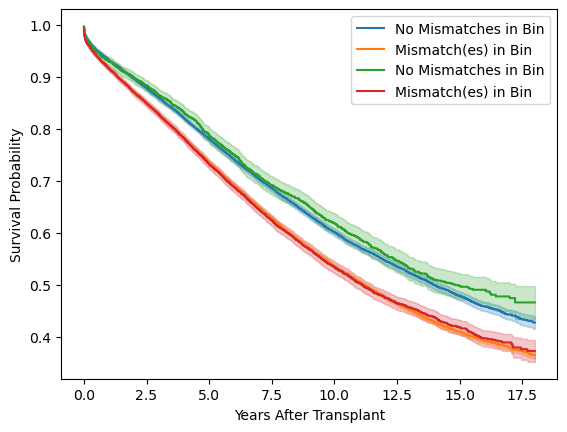

In [38]:
run_validation(0)

In [ ]:
# number_of_cores = int(os.environ['SLURM_CPUS_PER_TASK'])
# number_of_cores = 5

# from joblib import Parallel, delayed

# Parallel(n_jobs=number_of_cores, verbose=100)(delayed(run_validation)(i) for i in range(10))

Cross Validation 2
CV 1 Runtime 0:24:13.374688
Bin of Amino Acid Positions:
['DQB155', 'DRB113', 'C104', 'DQB174', 'DRB173', 'DRB187']
---
Number of Instances with No Mismatches in Bin:
33190
Number of Instances with Mismatch(es) in Bin:
116726
---
p-value from Log Rank Test:
7.675260219722232e-84


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         376.37 <0.005    276.10

Bin of Amino Acid Positions:
['DQB155', 'DRB113', 'C104', 'DQB174', 'DRB173', 'DRB187']
---
Number of Instances with No Mismatches in Bin:
3763
Number of Instances with Mismatch(es) in Bin:
12895
---
p-value from Log Rank Test:
1.1717924379224489e-09


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          37.02 <0.005     29.67

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.60499, step_size = 0.9500, log_lik = -601177.35272, newton_decrement = 5740.33890, seconds_since_start = 1.3
Iteration 2: norm_delta = 0.19976, step_size = 0.9500, log_lik = -595651.89907, newton_decrement = 128.81722, seconds_since_start = 2.6
Iteration 3: norm_delta = 0.02043, step_size = 0.9500, log_lik = -595520.67519, newton_decrement = 1.07102, seconds_since_start = 3.7
Iteration 4: norm_delta = 0.00013, step_size = 1.0000, log_lik = -595519.59978, newton_decrement = 0.00005, seconds_since_start = 4.8
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -595519.59973, newton_decrement = 0.00000, seconds_since_start = 5.9
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149916 total observations, 96428 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149916
number of events observed = 53488
   partial log-likelihood = -595519.60
         time fit was run = 2023-03-22 03:58:43 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.02       1.02       0.01             0.00             0.03                 1.00                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.18       0.83       0.11            -0.39             0.02                 0.68                 1.02
DCD                    0.08       1.08       0.02             0.05             0.11                 1.05                 1.11
ln_don_wgt_kg_0c      -0.53       0.59       0.07            -0.66            -0.39                 0.52                 0.67
ln_don_wgt_kg_0c_s55   0.51       1.66       0.08             0.36             0.65                 1.43                 1.92
dcadcodanox            0.04       1.04       0.01             0.02             0.07                 1.02                 1.07
dcadcodcva             0.07       1.07       0.01             0.05             0.09                 1.05                 1.10
dcadcodcnst            0.01       1.01       0.05            -0.10             0.11                 0.91                 1.12
dcadcodoth             0.06       1.07       0.03             0.01             0.12                 1.01                 1.13
don_ecd                0.26       1.29       0.06             0.15             0.37                 1.16                 1.44
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.13                 1.18
mmA0                  -0.05       0.95       0.02            -0.09            -0.02                 0.92                 0.98
mmA1                  -0.00       1.00       0.01            -0.02             0.01                 0.98                 1.01
mmB0                  -0.10       0.90       0.02            -0.15            -0.06                 0.86                 0.94
mmB1                  -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
mmDR0                 -0.06       0.94       0.02            -0.10            -0.02                 0.91                 0.98
mmDR1                 -0.04       0.96       0.01            -0.06            -0.02                 0.94                 0.98
mm0                    0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
mmC0                  -0.02       0.98       0.03            -0.08             0.03                 0.92                 1.03
mmC1                   0.03       1.04       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                  0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
mmDQ1                 -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
shared                 0.11       1.12       0.01             0.09             0.13                 1.10                 1.14
PKPRA_1080             0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
PKPRA_GE80             0.19       1.21       0.01             0.16             0.22            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.52951, step_size = 0.9500, log_lik = -54164.39885, newton_decrement = 685.36163, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.19426, step_size = 0.9500, log_lik = -53510.99616, newton_decrement = 18.94924, seconds_since_start = 0.6
Iteration 3: norm_delta = 0.02651, step_size = 0.9500, log_lik = -53491.52104, newton_decrement = 0.22631, seconds_since_start = 0.9
Iteration 4: norm_delta = 0.00027, step_size = 1.0000, log_lik = -53491.29321, newton_decrement = 0.00003, seconds_since_start = 1.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -53491.29318, newton_decrement = 0.00000, seconds_since_start = 1.4
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16658 total observations, 10667 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16658
number of events observed = 5991
   partial log-likelihood = -53491.29
         time fit was run = 2023-03-22 03:58:51 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.05       1.05       0.02             0.01             0.09                 1.01                 1.09
yearslice             -0.06       0.94       0.00            -0.06            -0.05                 0.94                 0.95
diab_noted             0.19       1.21       0.30            -0.39             0.78                 0.68                 2.17
DCD                    0.09       1.09       0.05            -0.00             0.18                 1.00                 1.19
ln_don_wgt_kg_0c      -0.01       0.99       0.21            -0.41             0.40                 0.66                 1.50
ln_don_wgt_kg_0c_s55  -0.08       0.93       0.23            -0.53             0.38                 0.59                 1.46
dcadcodanox            0.05       1.05       0.04            -0.03             0.13                 0.97                 1.14
dcadcodcva             0.04       1.04       0.03            -0.03             0.11                 0.97                 1.11
dcadcodcnst           -0.07       0.93       0.16            -0.38             0.24                 0.68                 1.27
dcadcodoth             0.01       1.01       0.08            -0.15             0.18                 0.86                 1.19
don_ecd                0.29       1.34       0.17            -0.05             0.63                 0.95                 1.88
don_htn_0c             0.13       1.14       0.03             0.06             0.20                 1.07                 1.22
mmA0                  -0.09       0.91       0.05            -0.20             0.02                 0.82                 1.02
mmA1                   0.02       1.02       0.03            -0.03             0.08                 0.97                 1.08
mmB0                  -0.04       0.96       0.07            -0.16             0.09                 0.85                 1.09
mmB1                   0.02       1.02       0.03            -0.04             0.09                 0.96                 1.09
mmDR0                 -0.04       0.96       0.06            -0.16             0.07                 0.86                 1.07
mmDR1                 -0.10       0.90       0.03            -0.16            -0.04                 0.85                 0.96
mm0                   -0.02       0.98       0.09            -0.18             0.15                 0.83                 1.16
mmC0                   0.11       1.12       0.09            -0.06             0.28                 0.94                 1.33
mmC1                   0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
mmDQ0                 -0.06       0.94       0.04            -0.14             0.02                 0.87                 1.02
mmDQ1                 -0.05       0.96       0.03            -0.10             0.01                 0.90                 1.01
shared                 0.10       1.11       0.03             0.04             0.17                 1.04                 1.18
PKPRA_1080             0.04       1.04       0.03            -0.03             0.10                 0.97                 1.10
PKPRA_GE80             0.18       1.20       0.04             0.10             0.27                

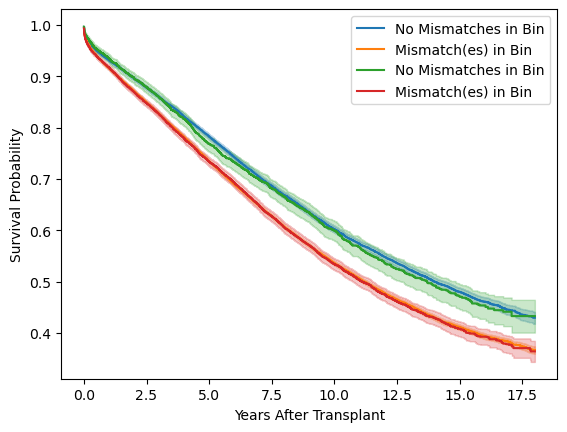

In [39]:
run_validation(1)

Cross Validation 3
CV 2 Runtime 0:24:23.898820
Bin of Amino Acid Positions:
['DQB152', 'C107', 'DRB137', 'DRB111', 'A175', 'DQB177', 'DRB130', 'DQB118', 'DQB185']
---
Number of Instances with No Mismatches in Bin:
32841
Number of Instances with Mismatch(es) in Bin:
117075
---
p-value from Log Rank Test:
2.1380782848495123e-82


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         369.73 <0.005    271.30

Bin of Amino Acid Positions:
['DQB152', 'C107', 'DRB137', 'DRB111', 'A175', 'DQB177', 'DRB130', 'DQB118', 'DQB185']
---
Number of Instances with No Mismatches in Bin:
3712
Number of Instances with Mismatch(es) in Bin:
12946
---
p-value from Log Rank Test:
9.093066308797733e-11


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          42.01 <0.005     33.36

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.55377, step_size = 0.9500, log_lik = -601187.77855, newton_decrement = 5741.61177, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.19430, step_size = 0.9500, log_lik = -595664.42955, newton_decrement = 130.65675, seconds_since_start = 1.9
Iteration 3: norm_delta = 0.02066, step_size = 0.9500, log_lik = -595531.25433, newton_decrement = 1.11488, seconds_since_start = 2.9
Iteration 4: norm_delta = 0.00013, step_size = 1.0000, log_lik = -595530.13469, newton_decrement = 0.00006, seconds_since_start = 3.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -595530.13463, newton_decrement = 0.00000, seconds_since_start = 4.9
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149916 total observations, 96425 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149916
number of events observed = 53491
   partial log-likelihood = -595530.13
         time fit was run = 2023-03-22 04:23:22 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.02       1.02       0.01            -0.00             0.03                 1.00                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.94                 0.95
diab_noted            -0.07       0.93       0.10            -0.28             0.13                 0.76                 1.14
DCD                    0.07       1.08       0.02             0.04             0.10                 1.04                 1.11
ln_don_wgt_kg_0c      -0.44       0.64       0.07            -0.57            -0.31                 0.56                 0.74
ln_don_wgt_kg_0c_s55   0.41       1.51       0.08             0.26             0.56                 1.30                 1.75
dcadcodanox            0.04       1.04       0.01             0.02             0.07                 1.02                 1.07
dcadcodcva             0.06       1.07       0.01             0.04             0.09                 1.04                 1.09
dcadcodcnst            0.00       1.00       0.05            -0.10             0.11                 0.90                 1.12
dcadcodoth             0.07       1.07       0.03             0.01             0.12                 1.01                 1.13
don_ecd                0.29       1.33       0.06             0.18             0.40                 1.19                 1.49
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.12                 1.17
mmA0                  -0.05       0.95       0.02            -0.09            -0.02                 0.92                 0.98
mmA1                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.10       0.91       0.02            -0.14            -0.06                 0.87                 0.95
mmB1                  -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
mmDR0                 -0.06       0.94       0.02            -0.10            -0.02                 0.91                 0.98
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.94                 0.97
mm0                    0.01       1.01       0.03            -0.05             0.06                 0.95                 1.07
mmC0                  -0.02       0.98       0.03            -0.08             0.04                 0.93                 1.04
mmC1                   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                 -0.01       0.99       0.01            -0.04             0.02                 0.97                 1.02
mmDQ1                 -0.02       0.98       0.01            -0.04             0.00                 0.97                 1.00
shared                 0.11       1.12       0.01             0.09             0.13                 1.09                 1.14
PKPRA_1080             0.05       1.05       0.01             0.03             0.07                 1.03                 1.08
PKPRA_GE80             0.19       1.20       0.01             0.16             0.21            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 1.01980, step_size = 0.9500, log_lik = -54159.79945, newton_decrement = 678.90320, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.24778, step_size = 0.9500, log_lik = -53508.64509, newton_decrement = 15.56160, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.02201, step_size = 0.9500, log_lik = -53492.77789, newton_decrement = 0.13481, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00013, step_size = 1.0000, log_lik = -53492.64250, newton_decrement = 0.00001, seconds_since_start = 1.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -53492.64250, newton_decrement = 0.00000, seconds_since_start = 1.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16658 total observations, 10670 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16658
number of events observed = 5988
   partial log-likelihood = -53492.64
         time fit was run = 2023-03-22 04:23:29 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.07       1.07       0.02             0.03             0.11                 1.03                 1.12
yearslice             -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
diab_noted            -0.89       0.41       0.33            -1.53            -0.25                 0.22                 0.78
DCD                    0.12       1.12       0.04             0.03             0.20                 1.03                 1.23
ln_don_wgt_kg_0c      -0.79       0.46       0.20            -1.18            -0.39                 0.31                 0.68
ln_don_wgt_kg_0c_s55   0.76       2.15       0.23             0.32             1.21                 1.37                 3.36
dcadcodanox            0.06       1.06       0.04            -0.01             0.14                 0.99                 1.15
dcadcodcva             0.10       1.11       0.03             0.04             0.17                 1.04                 1.19
dcadcodcnst           -0.05       0.95       0.18            -0.41             0.31                 0.66                 1.37
dcadcodoth            -0.00       1.00       0.09            -0.18             0.17                 0.83                 1.19
don_ecd                0.04       1.04       0.17            -0.29             0.37                 0.75                 1.45
don_htn_0c             0.14       1.15       0.03             0.08             0.21                 1.08                 1.23
mmA0                  -0.10       0.91       0.05            -0.20             0.00                 0.82                 1.00
mmA1                   0.00       1.00       0.03            -0.05             0.06                 0.95                 1.06
mmB0                  -0.08       0.92       0.07            -0.21             0.04                 0.81                 1.05
mmB1                  -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
mmDR0                 -0.07       0.93       0.06            -0.19             0.04                 0.83                 1.04
mmDR1                 -0.07       0.93       0.03            -0.13            -0.01                 0.88                 0.99
mm0                    0.05       1.05       0.09            -0.12             0.22                 0.89                 1.25
mmC0                   0.05       1.05       0.09            -0.13             0.23                 0.88                 1.26
mmC1                   0.01       1.01       0.04            -0.06             0.09                 0.94                 1.09
mmDQ0                 -0.06       0.94       0.04            -0.15             0.02                 0.86                 1.02
mmDQ1                 -0.06       0.94       0.03            -0.12            -0.01                 0.89                 0.99
shared                 0.11       1.11       0.03             0.05             0.17                 1.05                 1.19
PKPRA_1080            -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.07
PKPRA_GE80             0.19       1.21       0.04             0.11             0.28                

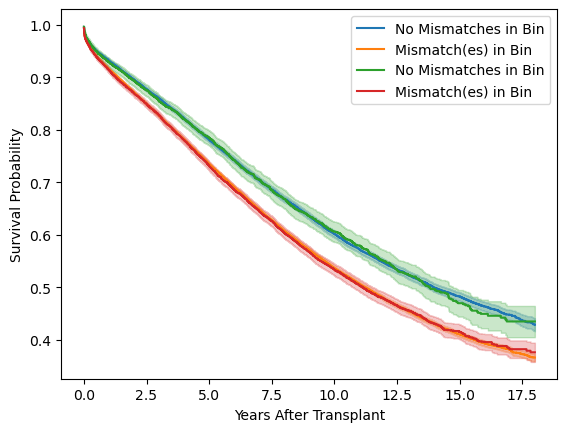

In [40]:
run_validation(2)

Cross Validation 4
CV 3 Runtime 0:24:17.769193
Bin of Amino Acid Positions:
['DRB112', 'DQB155', 'DRB173', 'A169', 'DQB174', 'DRB172', 'DQB116', 'A188', 'C180', 'C109', 'C82', 'C123', 'C92', 'C18', 'B137', 'DRB189', 'C200', 'C57']
---
Number of Instances with No Mismatches in Bin:
46196
Number of Instances with Mismatch(es) in Bin:
103720
---
p-value from Log Rank Test:
1.846217513358052e-92


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         415.96 <0.005    304.73

Bin of Amino Acid Positions:
['DRB112', 'DQB155', 'DRB173', 'A169', 'DQB174', 'DRB172', 'DQB116', 'A188', 'C180', 'C109', 'C82', 'C123', 'C92', 'C18', 'B137', 'DRB189', 'C200', 'C57']
---
Number of Instances with No Mismatches in Bin:
5045
Number of Instances with Mismatch(es) in Bin:
11613
---
p-value from Log Rank Test:
2.0016936918699156e-07


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          27.03 <0.005     22.25

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.61563, step_size = 0.9500, log_lik = -602171.87650, newton_decrement = 5777.40917, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.20011, step_size = 0.9500, log_lik = -596617.89900, newton_decrement = 132.82222, seconds_since_start = 2.0
Iteration 3: norm_delta = 0.02131, step_size = 0.9500, log_lik = -596482.42390, newton_decrement = 1.16834, seconds_since_start = 2.9
Iteration 4: norm_delta = 0.00014, step_size = 1.0000, log_lik = -596481.25035, newton_decrement = 0.00006, seconds_since_start = 3.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -596481.25028, newton_decrement = 0.00000, seconds_since_start = 4.9
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149916 total observations, 96338 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149916
number of events observed = 53578
   partial log-likelihood = -596481.25
         time fit was run = 2023-03-22 04:47:53 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.23       0.80       0.10            -0.43            -0.02                 0.65                 0.98
DCD                    0.08       1.08       0.02             0.05             0.11                 1.05                 1.11
ln_don_wgt_kg_0c      -0.48       0.62       0.07            -0.61            -0.35                 0.54                 0.71
ln_don_wgt_kg_0c_s55   0.46       1.58       0.08             0.31             0.61                 1.36                 1.83
dcadcodanox            0.04       1.04       0.01             0.02             0.07                 1.02                 1.07
dcadcodcva             0.07       1.07       0.01             0.05             0.09                 1.05                 1.10
dcadcodcnst           -0.00       1.00       0.05            -0.11             0.10                 0.90                 1.11
dcadcodoth             0.07       1.07       0.03             0.01             0.13                 1.01                 1.14
don_ecd                0.23       1.26       0.06             0.12             0.34                 1.13                 1.41
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.12                 1.17
mmA0                  -0.06       0.94       0.02            -0.10            -0.03                 0.91                 0.97
mmA1                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.10       0.91       0.02            -0.14            -0.06                 0.87                 0.95
mmB1                  -0.03       0.97       0.01            -0.05            -0.01                 0.95                 0.99
mmDR0                 -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
mmDR1                 -0.04       0.96       0.01            -0.06            -0.02                 0.94                 0.98
mm0                    0.00       1.00       0.03            -0.05             0.06                 0.95                 1.06
mmC0                  -0.02       0.98       0.03            -0.08             0.04                 0.93                 1.04
mmC1                   0.02       1.02       0.01             0.00             0.05                 1.00                 1.05
mmDQ0                  0.01       1.01       0.01            -0.02             0.03                 0.98                 1.04
mmDQ1                 -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
shared                 0.11       1.12       0.01             0.09             0.14                 1.10                 1.14
PKPRA_1080             0.05       1.05       0.01             0.03             0.07                 1.03                 1.07
PKPRA_GE80             0.19       1.21       0.01             0.16             0.22            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.68373, step_size = 0.9500, log_lik = -53367.64646, newton_decrement = 660.68254, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.19879, step_size = 0.9500, log_lik = -52730.16673, newton_decrement = 14.77926, seconds_since_start = 0.6
Iteration 3: norm_delta = 0.01788, step_size = 0.9500, log_lik = -52715.15197, newton_decrement = 0.10912, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00009, step_size = 1.0000, log_lik = -52715.04248, newton_decrement = 0.00000, seconds_since_start = 1.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -52715.04247, newton_decrement = 0.00000, seconds_since_start = 1.4
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16658 total observations, 10757 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16658
number of events observed = 5901
   partial log-likelihood = -52715.04
         time fit was run = 2023-03-22 04:48:00 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.08       1.08       0.02             0.03             0.12                 1.03                 1.13
yearslice             -0.06       0.95       0.00            -0.06            -0.05                 0.94                 0.95
diab_noted             0.61       1.84       0.31             0.00             1.22                 1.00                 3.38
DCD                    0.08       1.09       0.05            -0.01             0.17                 0.99                 1.19
ln_don_wgt_kg_0c      -0.38       0.68       0.21            -0.78             0.02                 0.46                 1.02
ln_don_wgt_kg_0c_s55   0.31       1.36       0.23            -0.14             0.76                 0.87                 2.13
dcadcodanox            0.07       1.07       0.04            -0.01             0.14                 0.99                 1.15
dcadcodcva             0.05       1.05       0.03            -0.02             0.12                 0.98                 1.12
dcadcodcnst           -0.02       0.98       0.18            -0.37             0.33                 0.69                 1.39
dcadcodoth            -0.05       0.96       0.09            -0.22             0.13                 0.80                 1.14
don_ecd                0.55       1.73       0.17             0.21             0.88                 1.24                 2.42
don_htn_0c             0.16       1.17       0.03             0.10             0.23                 1.10                 1.25
mmA0                  -0.04       0.96       0.05            -0.14             0.06                 0.87                 1.06
mmA1                   0.02       1.02       0.03            -0.04             0.07                 0.96                 1.07
mmB0                  -0.12       0.88       0.07            -0.25             0.01                 0.78                 1.01
mmB1                  -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.06
mmDR0                 -0.20       0.82       0.05            -0.31            -0.10                 0.74                 0.91
mmDR1                 -0.06       0.94       0.03            -0.12             0.00                 0.89                 1.00
mm0                    0.14       1.15       0.09            -0.03             0.31                 0.97                 1.36
mmC0                   0.05       1.05       0.09            -0.13             0.23                 0.88                 1.26
mmC1                   0.12       1.13       0.04             0.05             0.19                 1.05                 1.21
mmDQ0                 -0.00       1.00       0.04            -0.09             0.08                 0.91                 1.09
mmDQ1                 -0.01       0.99       0.03            -0.07             0.05                 0.94                 1.05
shared                 0.09       1.09       0.03             0.02             0.15                 1.02                 1.16
PKPRA_1080             0.05       1.06       0.03            -0.01             0.12                 0.99                 1.13
PKPRA_GE80             0.16       1.17       0.05             0.07             0.25                

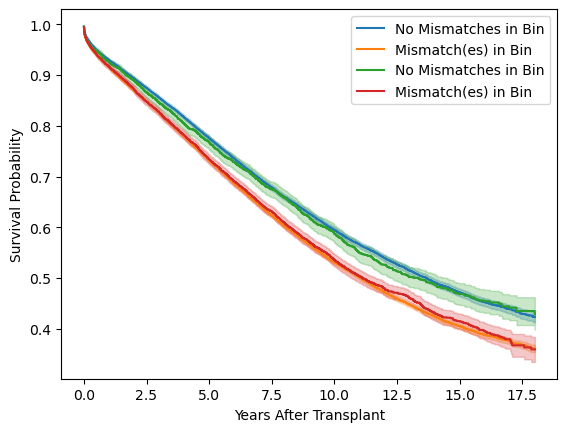

In [41]:
run_validation(3)

Cross Validation 5
CV 4 Runtime 0:24:12.843823
Bin of Amino Acid Positions:
['DRB113', 'DQB130', 'DQB155', 'DRB123', 'DRB126', 'A153']
---
Number of Instances with No Mismatches in Bin:
32393
Number of Instances with Mismatch(es) in Bin:
117524
---
p-value from Log Rank Test:
4.202193147933989e-88


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         395.95 <0.005    290.26

Bin of Amino Acid Positions:
['DRB113', 'DQB130', 'DQB155', 'DRB123', 'DRB126', 'A153']
---
Number of Instances with No Mismatches in Bin:
3541
Number of Instances with Mismatch(es) in Bin:
13116
---
p-value from Log Rank Test:
4.771807615962415e-07


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          25.35 <0.005     21.00

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.57688, step_size = 0.9500, log_lik = -602100.75430, newton_decrement = 5700.01671, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.19393, step_size = 0.9500, log_lik = -596619.48611, newton_decrement = 128.57469, seconds_since_start = 1.8
Iteration 3: norm_delta = 0.02046, step_size = 0.9500, log_lik = -596488.45430, newton_decrement = 1.08941, seconds_since_start = 2.9
Iteration 4: norm_delta = 0.00013, step_size = 1.0000, log_lik = -596487.36030, newton_decrement = 0.00005, seconds_since_start = 3.9
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -596487.36024, newton_decrement = 0.00000, seconds_since_start = 4.7
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149917 total observations, 96350 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149917
number of events observed = 53567
   partial log-likelihood = -596487.36
         time fit was run = 2023-03-22 05:12:19 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.02       1.02       0.01             0.01             0.04                 1.01                 1.04
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.15       0.86       0.10            -0.35             0.06                 0.70                 1.06
DCD                    0.07       1.08       0.02             0.04             0.10                 1.05                 1.11
ln_don_wgt_kg_0c      -0.48       0.62       0.07            -0.61            -0.34                 0.54                 0.71
ln_don_wgt_kg_0c_s55   0.45       1.57       0.08             0.31             0.60                 1.36                 1.83
dcadcodanox            0.04       1.05       0.01             0.02             0.07                 1.02                 1.07
dcadcodcva             0.06       1.07       0.01             0.04             0.09                 1.04                 1.09
dcadcodcnst           -0.02       0.98       0.05            -0.12             0.09                 0.88                 1.10
dcadcodoth             0.05       1.05       0.03            -0.01             0.11                 0.99                 1.11
don_ecd                0.28       1.32       0.06             0.16             0.39                 1.18                 1.47
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.13                 1.18
mmA0                  -0.06       0.94       0.02            -0.10            -0.03                 0.91                 0.97
mmA1                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.09       0.91       0.02            -0.14            -0.05                 0.87                 0.95
mmB1                  -0.03       0.98       0.01            -0.05            -0.00                 0.96                 1.00
mmDR0                 -0.06       0.94       0.02            -0.10            -0.02                 0.91                 0.98
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
mm0                    0.01       1.01       0.03            -0.05             0.06                 0.95                 1.07
mmC0                  -0.02       0.98       0.03            -0.08             0.04                 0.93                 1.04
mmC1                   0.04       1.04       0.01             0.02             0.06                 1.02                 1.07
mmDQ0                 -0.01       0.99       0.01            -0.04             0.02                 0.96                 1.02
mmDQ1                 -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
shared                 0.12       1.12       0.01             0.09             0.14                 1.10                 1.15
PKPRA_1080             0.05       1.05       0.01             0.02             0.07                 1.03                 1.07
PKPRA_GE80             0.18       1.20       0.01             0.15             0.21            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.58145, step_size = 0.9500, log_lik = -53414.45342, newton_decrement = 733.57522, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.22188, step_size = 0.9500, log_lik = -52709.06642, newton_decrement = 19.18839, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.02636, step_size = 0.9500, log_lik = -52689.41748, newton_decrement = 0.19953, seconds_since_start = 0.7
Iteration 4: norm_delta = 0.00024, step_size = 1.0000, log_lik = -52689.21683, newton_decrement = 0.00002, seconds_since_start = 1.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -52689.21681, newton_decrement = 0.00000, seconds_since_start = 1.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16657 total observations, 10745 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16657
number of events observed = 5912
   partial log-likelihood = -52689.22
         time fit was run = 2023-03-22 05:12:26 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.06       1.06       0.01             0.03             0.09                 1.03                 1.09
yearslice             -0.06       0.95       0.00            -0.06            -0.05                 0.94                 0.95
diab_noted            -0.02       0.98       0.32            -0.65             0.61                 0.52                 1.83
DCD                    0.12       1.12       0.05             0.03             0.21                 1.03                 1.23
ln_don_wgt_kg_0c      -0.43       0.65       0.20            -0.83            -0.03                 0.44                 0.97
ln_don_wgt_kg_0c_s55   0.34       1.41       0.23            -0.11             0.79                 0.90                 2.20
dcadcodanox            0.03       1.03       0.04            -0.05             0.11                 0.95                 1.11
dcadcodcva             0.10       1.11       0.03             0.04             0.17                 1.04                 1.19
dcadcodcnst            0.13       1.13       0.15            -0.17             0.42                 0.84                 1.52
dcadcodoth             0.18       1.19       0.09             0.00             0.35                 1.00                 1.42
don_ecd                0.13       1.14       0.17            -0.20             0.47                 0.81                 1.60
don_htn_0c             0.14       1.15       0.03             0.07             0.20                 1.07                 1.22
mmA0                   0.00       1.00       0.05            -0.10             0.11                 0.90                 1.11
mmA1                  -0.01       0.99       0.03            -0.06             0.05                 0.94                 1.05
mmB0                  -0.11       0.90       0.07            -0.24             0.02                 0.79                 1.02
mmB1                  -0.01       0.99       0.03            -0.07             0.05                 0.93                 1.05
mmDR0                 -0.04       0.96       0.06            -0.15             0.07                 0.86                 1.07
mmDR1                 -0.03       0.97       0.03            -0.09             0.03                 0.91                 1.03
mm0                    0.01       1.01       0.09            -0.16             0.18                 0.85                 1.20
mmC0                   0.04       1.04       0.09            -0.14             0.22                 0.87                 1.24
mmC1                  -0.02       0.98       0.04            -0.09             0.05                 0.91                 1.05
mmDQ0                 -0.01       0.99       0.04            -0.09             0.07                 0.91                 1.08
mmDQ1                 -0.00       1.00       0.03            -0.06             0.05                 0.94                 1.05
shared                 0.07       1.08       0.03             0.01             0.14                 1.01                 1.15
PKPRA_1080             0.07       1.07       0.03             0.00             0.13                 1.00                 1.14
PKPRA_GE80             0.24       1.27       0.04             0.15             0.33                

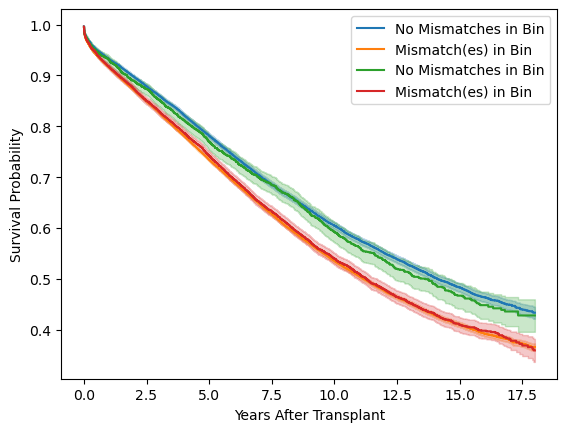

In [42]:
run_validation(4)

Cross Validation 6
CV 5 Runtime 0:24:03.568029
Bin of Amino Acid Positions:
['DQB174', 'DQB155', 'C192', 'DQB128', 'C162', 'DRB112', 'DQB181', 'DRB140', 'DRB132', 'C50', 'C165', 'C7', 'C122', 'DRB173', 'B43']
---
Number of Instances with No Mismatches in Bin:
41861
Number of Instances with Mismatch(es) in Bin:
108056
---
p-value from Log Rank Test:
1.4238720818494043e-92


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         416.48 <0.005    305.11

Bin of Amino Acid Positions:
['DQB174', 'DQB155', 'C192', 'DQB128', 'C162', 'DRB112', 'DQB181', 'DRB140', 'DRB132', 'C50', 'C165', 'C7', 'C122', 'DRB173', 'B43']
---
Number of Instances with No Mismatches in Bin:
4619
Number of Instances with Mismatch(es) in Bin:
12038
---
p-value from Log Rank Test:
3.178265274769738e-09


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          35.07 <0.005     28.23

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.59600, step_size = 0.9500, log_lik = -601327.89109, newton_decrement = 5774.50616, seconds_since_start = 1.1
Iteration 2: norm_delta = 0.19571, step_size = 0.9500, log_lik = -595770.98481, newton_decrement = 132.38108, seconds_since_start = 2.1
Iteration 3: norm_delta = 0.02076, step_size = 0.9500, log_lik = -595635.98938, newton_decrement = 1.14998, seconds_since_start = 3.1
Iteration 4: norm_delta = 0.00014, step_size = 1.0000, log_lik = -595634.83440, newton_decrement = 0.00006, seconds_since_start = 4.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -595634.83434, newton_decrement = 0.00000, seconds_since_start = 4.9
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149917 total observations, 96411 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149917
number of events observed = 53506
   partial log-likelihood = -595634.83
         time fit was run = 2023-03-22 05:36:36 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.01       1.01       0.01            -0.01             0.03                 0.99                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.94                 0.95
diab_noted            -0.16       0.86       0.10            -0.36             0.05                 0.70                 1.05
DCD                    0.08       1.08       0.02             0.05             0.11                 1.05                 1.11
ln_don_wgt_kg_0c      -0.47       0.62       0.07            -0.60            -0.34                 0.55                 0.71
ln_don_wgt_kg_0c_s55   0.45       1.56       0.08             0.30             0.59                 1.35                 1.81
dcadcodanox            0.05       1.05       0.01             0.02             0.07                 1.02                 1.08
dcadcodcva             0.07       1.07       0.01             0.04             0.09                 1.04                 1.09
dcadcodcnst            0.01       1.01       0.05            -0.09             0.12                 0.91                 1.12
dcadcodoth             0.05       1.05       0.03            -0.01             0.11                 0.99                 1.11
don_ecd                0.26       1.30       0.06             0.15             0.37                 1.16                 1.45
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.13                 1.18
mmA0                  -0.06       0.94       0.02            -0.09            -0.03                 0.91                 0.97
mmA1                   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.10       0.90       0.02            -0.14            -0.06                 0.87                 0.94
mmB1                  -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
mmDR0                 -0.06       0.94       0.02            -0.10            -0.03                 0.91                 0.97
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
mm0                    0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
mmC0                   0.01       1.01       0.03            -0.05             0.06                 0.95                 1.07
mmC1                   0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                  0.00       1.00       0.01            -0.03             0.03                 0.97                 1.03
mmDQ1                 -0.01       0.99       0.01            -0.03             0.00                 0.97                 1.00
shared                 0.11       1.12       0.01             0.09             0.14                 1.10                 1.15
PKPRA_1080             0.04       1.05       0.01             0.02             0.07                 1.02                 1.07
PKPRA_GE80             0.18       1.19       0.01             0.15             0.21            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.49770, step_size = 0.9500, log_lik = -54053.49430, newton_decrement = 656.89677, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.20863, step_size = 0.9500, log_lik = -53424.34432, newton_decrement = 15.46030, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.02178, step_size = 0.9500, log_lik = -53408.59973, newton_decrement = 0.13118, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00015, step_size = 1.0000, log_lik = -53408.46795, newton_decrement = 0.00001, seconds_since_start = 1.1
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -53408.46794, newton_decrement = 0.00000, seconds_since_start = 1.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16657 total observations, 10684 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16657
number of events observed = 5973
   partial log-likelihood = -53408.47
         time fit was run = 2023-03-22 05:36:42 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.04       1.04       0.02            -0.00             0.07                 1.00                 1.07
yearslice             -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
diab_noted             0.01       1.01       0.31            -0.60             0.62                 0.55                 1.87
DCD                    0.10       1.11       0.05             0.01             0.19                 1.01                 1.21
ln_don_wgt_kg_0c      -0.52       0.60       0.21            -0.94            -0.09                 0.39                 0.91
ln_don_wgt_kg_0c_s55   0.45       1.58       0.24            -0.01             0.92                 0.99                 2.52
dcadcodanox            0.01       1.01       0.04            -0.07             0.09                 0.93                 1.09
dcadcodcva             0.08       1.09       0.03             0.02             0.15                 1.02                 1.16
dcadcodcnst           -0.12       0.88       0.18            -0.47             0.22                 0.62                 1.25
dcadcodoth             0.15       1.16       0.09            -0.02             0.32                 0.98                 1.37
don_ecd                0.29       1.33       0.17            -0.04             0.62                 0.96                 1.85
don_htn_0c             0.13       1.14       0.03             0.07             0.20                 1.07                 1.22
mmA0                  -0.05       0.95       0.05            -0.15             0.06                 0.86                 1.06
mmA1                  -0.01       0.99       0.03            -0.07             0.04                 0.93                 1.04
mmB0                  -0.07       0.93       0.07            -0.20             0.06                 0.82                 1.06
mmB1                  -0.07       0.93       0.03            -0.13            -0.01                 0.88                 0.99
mmDR0                 -0.10       0.90       0.05            -0.20             0.00                 0.82                 1.00
mmDR1                 -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
mm0                    0.01       1.01       0.08            -0.16             0.18                 0.86                 1.19
mmC0                  -0.13       0.87       0.09            -0.30             0.04                 0.74                 1.04
mmC1                   0.03       1.03       0.04            -0.04             0.10                 0.96                 1.11
mmDQ0                  0.01       1.01       0.04            -0.08             0.09                 0.93                 1.10
mmDQ1                 -0.08       0.93       0.03            -0.13            -0.02                 0.87                 0.98
shared                 0.09       1.09       0.03             0.02             0.15                 1.02                 1.16
PKPRA_1080             0.08       1.08       0.03             0.01             0.14                 1.01                 1.15
PKPRA_GE80             0.27       1.31       0.04             0.19             0.36                

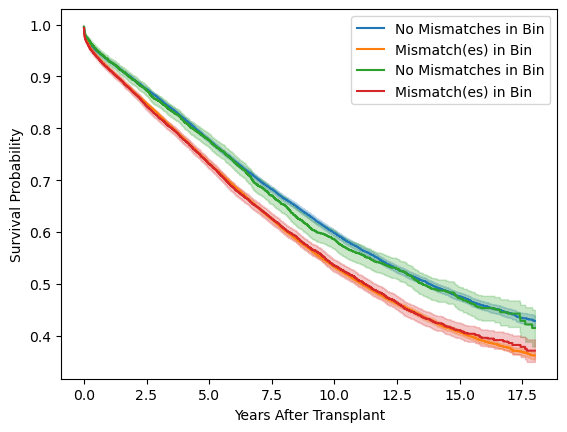

In [43]:
run_validation(5)

Cross Validation 7
CV 6 Runtime 0:24:02.963955
Bin of Amino Acid Positions:
['DRB126', 'DRB132', 'B192', 'DRB113', 'C54', 'DQB185', 'A186', 'DRB150', 'C25']
---
Number of Instances with No Mismatches in Bin:
37392
Number of Instances with Mismatch(es) in Bin:
112525
---
p-value from Log Rank Test:
3.9176317530171852e-90


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         405.27 <0.005    297.00

Bin of Amino Acid Positions:
['DRB126', 'DRB132', 'B192', 'DRB113', 'C54', 'DQB185', 'A186', 'DRB150', 'C25']
---
Number of Instances with No Mismatches in Bin:
4082
Number of Instances with Mismatch(es) in Bin:
12575
---
p-value from Log Rank Test:
7.697043450312519e-05


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          15.63 <0.005     13.67

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.59418, step_size = 0.9500, log_lik = -601353.90755, newton_decrement = 5742.00826, seconds_since_start = 0.9
Iteration 2: norm_delta = 0.19513, step_size = 0.9500, log_lik = -595825.26668, newton_decrement = 127.14279, seconds_since_start = 1.9
Iteration 3: norm_delta = 0.02016, step_size = 0.9500, log_lik = -595695.76097, newton_decrement = 1.05294, seconds_since_start = 2.8
Iteration 4: norm_delta = 0.00012, step_size = 1.0000, log_lik = -595694.70374, newton_decrement = 0.00005, seconds_since_start = 3.7
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -595694.70369, newton_decrement = 0.00000, seconds_since_start = 4.6
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149917 total observations, 96415 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149917
number of events observed = 53502
   partial log-likelihood = -595694.70
         time fit was run = 2023-03-22 06:00:52 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.02       1.02       0.01            -0.00             0.03                 1.00                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.16       0.85       0.10            -0.37             0.05                 0.69                 1.05
DCD                    0.08       1.09       0.02             0.05             0.11                 1.05                 1.12
ln_don_wgt_kg_0c      -0.48       0.62       0.07            -0.61            -0.35                 0.54                 0.71
ln_don_wgt_kg_0c_s55   0.45       1.57       0.08             0.30             0.60                 1.35                 1.82
dcadcodanox            0.05       1.05       0.01             0.02             0.07                 1.02                 1.07
dcadcodcva             0.07       1.07       0.01             0.05             0.09                 1.05                 1.10
dcadcodcnst            0.01       1.01       0.05            -0.10             0.11                 0.90                 1.12
dcadcodoth             0.05       1.05       0.03            -0.00             0.11                 1.00                 1.12
don_ecd                0.26       1.30       0.06             0.15             0.37                 1.16                 1.45
don_htn_0c             0.13       1.14       0.01             0.11             0.16                 1.12                 1.17
mmA0                  -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
mmA1                   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.09       0.92       0.02            -0.13            -0.04                 0.88                 0.96
mmB1                  -0.02       0.98       0.01            -0.05            -0.00                 0.96                 1.00
mmDR0                 -0.05       0.95       0.02            -0.09            -0.01                 0.91                 0.99
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
mm0                   -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
mmC0                  -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
mmC1                   0.03       1.03       0.01             0.01             0.05                 1.01                 1.06
mmDQ0                 -0.02       0.98       0.01            -0.05             0.01                 0.95                 1.01
mmDQ1                 -0.03       0.98       0.01            -0.04            -0.01                 0.96                 0.99
shared                 0.11       1.11       0.01             0.09             0.13                 1.09                 1.14
PKPRA_1080             0.05       1.05       0.01             0.02             0.07                 1.03                 1.07
PKPRA_GE80             0.19       1.21       0.01             0.16             0.22            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.53953, step_size = 0.9500, log_lik = -54018.11434, newton_decrement = 674.72295, seconds_since_start = 0.3
Iteration 2: norm_delta = 0.22139, step_size = 0.9500, log_lik = -53379.43824, newton_decrement = 21.12290, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.02917, step_size = 0.9500, log_lik = -53357.68671, newton_decrement = 0.27396, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00033, step_size = 1.0000, log_lik = -53357.41065, newton_decrement = 0.00004, seconds_since_start = 1.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -53357.41061, newton_decrement = 0.00000, seconds_since_start = 1.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16657 total observations, 10680 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16657
number of events observed = 5977
   partial log-likelihood = -53357.41
         time fit was run = 2023-03-22 06:00:58 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.02       1.03       0.02            -0.02             0.07                 0.98                 1.07
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.94                 0.96
diab_noted            -0.12       0.88       0.32            -0.74             0.50                 0.48                 1.64
DCD                    0.04       1.04       0.05            -0.05             0.13                 0.95                 1.13
ln_don_wgt_kg_0c      -0.44       0.64       0.20            -0.85            -0.04                 0.43                 0.96
ln_don_wgt_kg_0c_s55   0.41       1.51       0.23            -0.04             0.86                 0.96                 2.37
dcadcodanox            0.03       1.03       0.04            -0.05             0.10                 0.95                 1.11
dcadcodcva             0.06       1.06       0.03            -0.01             0.13                 0.99                 1.13
dcadcodcnst           -0.04       0.96       0.16            -0.36             0.28                 0.70                 1.33
dcadcodoth             0.12       1.12       0.08            -0.05             0.28                 0.96                 1.32
don_ecd                0.27       1.30       0.17            -0.08             0.61                 0.93                 1.83
don_htn_0c             0.20       1.22       0.03             0.13             0.26                 1.14                 1.30
mmA0                  -0.06       0.94       0.05            -0.16             0.04                 0.85                 1.04
mmA1                  -0.02       0.98       0.03            -0.07             0.04                 0.93                 1.04
mmB0                  -0.18       0.84       0.07            -0.31            -0.05                 0.74                 0.95
mmB1                  -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
mmDR0                 -0.04       0.96       0.06            -0.17             0.08                 0.85                 1.08
mmDR1                 -0.02       0.98       0.03            -0.08             0.04                 0.93                 1.04
mm0                    0.04       1.04       0.09            -0.14             0.21                 0.87                 1.23
mmC0                  -0.07       0.93       0.09            -0.25             0.11                 0.78                 1.12
mmC1                   0.07       1.07       0.04            -0.00             0.14                 1.00                 1.15
mmDQ0                 -0.00       1.00       0.04            -0.08             0.08                 0.92                 1.09
mmDQ1                  0.02       1.02       0.03            -0.04             0.08                 0.96                 1.08
shared                 0.13       1.14       0.03             0.07             0.20                 1.07                 1.22
PKPRA_1080             0.06       1.07       0.03             0.00             0.13                 1.00                 1.13
PKPRA_GE80             0.16       1.17       0.05             0.07             0.25                

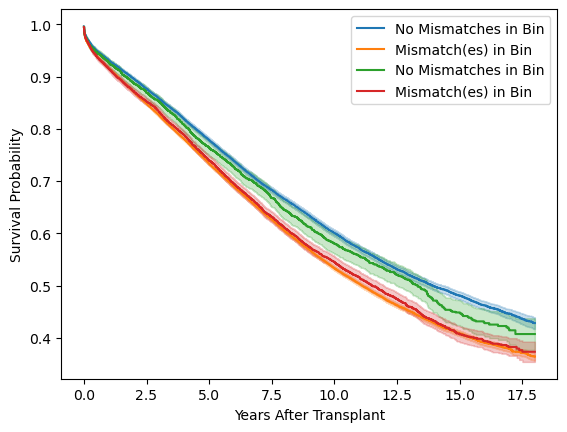

In [44]:
run_validation(6)

Cross Validation 8
CV 7 Runtime 0:24:07.850236
Bin of Amino Acid Positions:
['C111', 'DRB113', 'B139', 'A188', 'DQB184', 'DRB126', 'DRB132', 'C145', 'C154', 'C165']
---
Number of Instances with No Mismatches in Bin:
37893
Number of Instances with Mismatch(es) in Bin:
112024
---
p-value from Log Rank Test:
9.670678466934298e-88


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         394.28 <0.005    289.06

Bin of Amino Acid Positions:
['C111', 'DRB113', 'B139', 'A188', 'DQB184', 'DRB126', 'DRB132', 'C145', 'C154', 'C165']
---
Number of Instances with No Mismatches in Bin:
4213
Number of Instances with Mismatch(es) in Bin:
12444
---
p-value from Log Rank Test:
6.594540723699768e-07


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          24.73 <0.005     20.53

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.57689, step_size = 0.9500, log_lik = -601326.05375, newton_decrement = 5835.72656, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.20263, step_size = 0.9500, log_lik = -595733.05208, newton_decrement = 142.95188, seconds_since_start = 2.0
Iteration 3: norm_delta = 0.02286, step_size = 0.9500, log_lik = -595586.99592, newton_decrement = 1.34816, seconds_since_start = 2.9
Iteration 4: norm_delta = 0.00017, step_size = 1.0000, log_lik = -595585.64116, newton_decrement = 0.00009, seconds_since_start = 4.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -595585.64108, newton_decrement = 0.00000, seconds_since_start = 5.0
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149917 total observations, 96421 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149917
number of events observed = 53496
   partial log-likelihood = -595585.64
         time fit was run = 2023-03-22 06:25:12 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.16       0.85       0.11            -0.37             0.05                 0.69                 1.05
DCD                    0.08       1.08       0.02             0.05             0.10                 1.05                 1.11
ln_don_wgt_kg_0c      -0.46       0.63       0.07            -0.59            -0.33                 0.55                 0.72
ln_don_wgt_kg_0c_s55   0.44       1.55       0.08             0.29             0.59                 1.33                 1.80
dcadcodanox            0.04       1.04       0.01             0.01             0.06                 1.01                 1.07
dcadcodcva             0.07       1.07       0.01             0.05             0.09                 1.05                 1.10
dcadcodcnst            0.02       1.02       0.05            -0.09             0.12                 0.92                 1.13
dcadcodoth             0.06       1.06       0.03             0.00             0.12                 1.00                 1.13
don_ecd                0.26       1.29       0.06             0.14             0.37                 1.16                 1.44
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.12                 1.17
mmA0                  -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
mmA1                   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.11       0.90       0.02            -0.15            -0.06                 0.86                 0.94
mmB1                  -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
mmDR0                 -0.04       0.96       0.02            -0.09            -0.00                 0.92                 1.00
mmDR1                 -0.04       0.96       0.01            -0.06            -0.02                 0.94                 0.98
mm0                    0.01       1.01       0.03            -0.05             0.07                 0.95                 1.07
mmC0                  -0.02       0.98       0.03            -0.08             0.04                 0.93                 1.04
mmC1                   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                 -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
mmDQ1                 -0.02       0.98       0.01            -0.04            -0.01                 0.96                 0.99
shared                 0.11       1.12       0.01             0.09             0.13                 1.10                 1.14
PKPRA_1080             0.04       1.04       0.01             0.02             0.06                 1.02                 1.06
PKPRA_GE80             0.19       1.21       0.01             0.16             0.22            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.68863, step_size = 0.9500, log_lik = -54032.43985, newton_decrement = 597.17775, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.16077, step_size = 0.9500, log_lik = -53445.16664, newton_decrement = 7.92277, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.01088, step_size = 0.9500, log_lik = -53437.20638, newton_decrement = 0.03256, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00002, step_size = 1.0000, log_lik = -53437.17378, newton_decrement = 0.00000, seconds_since_start = 1.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -53437.17378, newton_decrement = 0.00000, seconds_since_start = 1.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16657 total observations, 10674 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16657
number of events observed = 5983
   partial log-likelihood = -53437.17
         time fit was run = 2023-03-22 06:25:19 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.05       1.05       0.03             0.00             0.10                 1.00                 1.11
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.94                 0.95
diab_noted            -0.11       0.90       0.30            -0.70             0.49                 0.50                 1.63
DCD                    0.11       1.11       0.05             0.02             0.20                 1.02                 1.22
ln_don_wgt_kg_0c      -0.60       0.55       0.20            -0.99            -0.22                 0.37                 0.80
ln_don_wgt_kg_0c_s55   0.55       1.73       0.22             0.12             0.98                 1.13                 2.67
dcadcodanox            0.09       1.09       0.04             0.01             0.16                 1.01                 1.18
dcadcodcva             0.04       1.04       0.03            -0.03             0.11                 0.97                 1.11
dcadcodcnst           -0.16       0.85       0.17            -0.49             0.17                 0.61                 1.18
dcadcodoth             0.04       1.04       0.09            -0.14             0.22                 0.87                 1.24
don_ecd                0.30       1.35       0.17            -0.03             0.63                 0.97                 1.88
don_htn_0c             0.15       1.16       0.03             0.08             0.21                 1.09                 1.24
mmA0                  -0.05       0.96       0.05            -0.15             0.06                 0.86                 1.06
mmA1                  -0.02       0.98       0.03            -0.08             0.04                 0.92                 1.04
mmB0                  -0.01       0.99       0.06            -0.13             0.12                 0.87                 1.12
mmB1                  -0.04       0.96       0.03            -0.10             0.02                 0.90                 1.02
mmDR0                 -0.05       0.96       0.06            -0.17             0.08                 0.84                 1.08
mmDR1                 -0.06       0.94       0.03            -0.12            -0.00                 0.88                 1.00
mm0                   -0.07       0.93       0.08            -0.24             0.10                 0.79                 1.10
mmC0                   0.09       1.10       0.09            -0.08             0.27                 0.92                 1.31
mmC1                   0.01       1.01       0.04            -0.06             0.08                 0.94                 1.08
mmDQ0                 -0.04       0.96       0.04            -0.12             0.04                 0.88                 1.05
mmDQ1                  0.01       1.01       0.03            -0.05             0.07                 0.95                 1.07
shared                 0.11       1.11       0.03             0.04             0.17                 1.05                 1.19
PKPRA_1080             0.14       1.15       0.03             0.07             0.20                 1.08                 1.22
PKPRA_GE80             0.15       1.16       0.04             0.06             0.24                

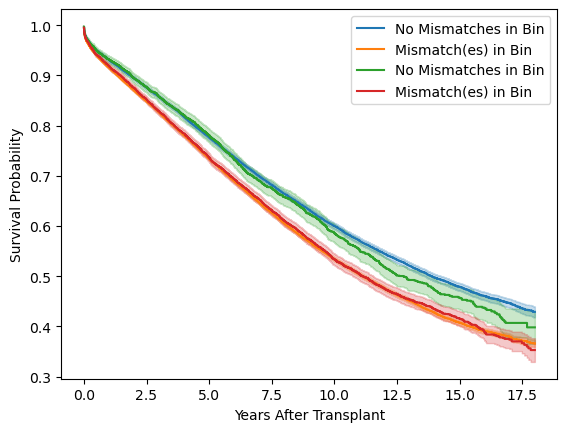

In [45]:
run_validation(7)

Cross Validation 9
CV 8 Runtime 0:24:06.067175
Bin of Amino Acid Positions:
['DQB155', 'DRB113', 'C7', 'B79', 'DQB175', 'C185', 'DRB132', 'C89']
---
Number of Instances with No Mismatches in Bin:
32236
Number of Instances with Mismatch(es) in Bin:
117681
---
p-value from Log Rank Test:
4.032345069546578e-81


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         363.88 <0.005    267.06

Bin of Amino Acid Positions:
['DQB155', 'DRB113', 'C7', 'B79', 'DQB175', 'C185', 'DRB132', 'C89']
---
Number of Instances with No Mismatches in Bin:
3578
Number of Instances with Mismatch(es) in Bin:
13079
---
p-value from Log Rank Test:
2.869423493932856e-13


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          53.30 <0.005     41.66

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.55306, step_size = 0.9500, log_lik = -602444.03640, newton_decrement = 5799.42741, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.19683, step_size = 0.9500, log_lik = -596869.86880, newton_decrement = 134.74566, seconds_since_start = 1.9
Iteration 3: norm_delta = 0.02118, step_size = 0.9500, log_lik = -596732.41534, newton_decrement = 1.19197, seconds_since_start = 2.8
Iteration 4: norm_delta = 0.00014, step_size = 1.0000, log_lik = -596731.21800, newton_decrement = 0.00007, seconds_since_start = 3.8
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -596731.21793, newton_decrement = 0.00000, seconds_since_start = 4.7
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149917 total observations, 96318 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149917
number of events observed = 53599
   partial log-likelihood = -596731.22
         time fit was run = 2023-03-22 06:49:31 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.02       1.02       0.01             0.00             0.04                 1.00                 1.04
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.08       0.93       0.10            -0.28             0.13                 0.75                 1.14
DCD                    0.08       1.09       0.02             0.05             0.11                 1.06                 1.12
ln_don_wgt_kg_0c      -0.43       0.65       0.07            -0.56            -0.29                 0.57                 0.75
ln_don_wgt_kg_0c_s55   0.38       1.47       0.08             0.23             0.53                 1.26                 1.70
dcadcodanox            0.04       1.04       0.01             0.01             0.07                 1.02                 1.07
dcadcodcva             0.07       1.07       0.01             0.04             0.09                 1.05                 1.09
dcadcodcnst           -0.01       0.99       0.05            -0.12             0.10                 0.89                 1.10
dcadcodoth             0.05       1.05       0.03            -0.01             0.11                 0.99                 1.11
don_ecd                0.26       1.30       0.06             0.15             0.37                 1.16                 1.45
don_htn_0c             0.15       1.16       0.01             0.12             0.17                 1.13                 1.18
mmA0                  -0.06       0.94       0.02            -0.09            -0.02                 0.91                 0.98
mmA1                  -0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.09       0.92       0.02            -0.13            -0.05                 0.88                 0.96
mmB1                  -0.02       0.98       0.01            -0.04            -0.00                 0.96                 1.00
mmDR0                 -0.05       0.95       0.02            -0.09            -0.01                 0.91                 0.99
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
mm0                    0.01       1.01       0.03            -0.05             0.07                 0.96                 1.07
mmC0                  -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
mmC1                   0.03       1.03       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                 -0.01       0.99       0.01            -0.04             0.02                 0.96                 1.02
mmDQ1                 -0.03       0.97       0.01            -0.04            -0.01                 0.96                 0.99
shared                 0.11       1.11       0.01             0.09             0.13                 1.09                 1.14
PKPRA_1080             0.05       1.05       0.01             0.03             0.07                 1.03                 1.08
PKPRA_GE80             0.19       1.21       0.01             0.16             0.22            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.93694, step_size = 0.9500, log_lik = -53140.57464, newton_decrement = 629.95980, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.19839, step_size = 0.9500, log_lik = -52532.02165, newton_decrement = 12.48772, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.01858, step_size = 0.9500, log_lik = -52519.36209, newton_decrement = 0.08202, seconds_since_start = 0.7
Iteration 4: norm_delta = 0.00008, step_size = 1.0000, log_lik = -52519.27985, newton_decrement = 0.00000, seconds_since_start = 1.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -52519.27985, newton_decrement = 0.00000, seconds_since_start = 1.2
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16657 total observations, 10777 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16657
number of events observed = 5880
   partial log-likelihood = -52519.28
         time fit was run = 2023-03-22 06:49:38 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX         -0.06       0.94       0.02            -0.10            -0.03                 0.91                 0.97
yearslice             -0.06       0.94       0.00            -0.07            -0.05                 0.94                 0.95
diab_noted            -0.68       0.51       0.32            -1.32            -0.05                 0.27                 0.95
DCD                    0.02       1.02       0.05            -0.07             0.11                 0.93                 1.11
ln_don_wgt_kg_0c      -0.85       0.43       0.18            -1.21            -0.49                 0.30                 0.61
ln_don_wgt_kg_0c_s55   0.97       2.65       0.21             0.56             1.38                 1.76                 3.99
dcadcodanox            0.07       1.08       0.04            -0.01             0.15                 0.99                 1.16
dcadcodcva             0.08       1.08       0.04             0.01             0.15                 1.01                 1.16
dcadcodcnst            0.09       1.09       0.16            -0.22             0.40                 0.80                 1.49
dcadcodoth             0.14       1.15       0.08            -0.03             0.30                 0.97                 1.35
don_ecd                0.24       1.28       0.17            -0.09             0.57                 0.92                 1.78
don_htn_0c             0.08       1.09       0.03             0.02             0.15                 1.02                 1.16
mmA0                  -0.05       0.95       0.05            -0.16             0.05                 0.86                 1.05
mmA1                  -0.00       1.00       0.03            -0.06             0.06                 0.94                 1.06
mmB0                  -0.13       0.88       0.07            -0.26            -0.00                 0.77                 1.00
mmB1                  -0.03       0.97       0.03            -0.09             0.04                 0.92                 1.04
mmDR0                 -0.08       0.92       0.06            -0.20             0.03                 0.82                 1.03
mmDR1                 -0.07       0.94       0.03            -0.13            -0.01                 0.88                 0.99
mm0                   -0.02       0.98       0.09            -0.19             0.15                 0.83                 1.16
mmC0                  -0.07       0.93       0.09            -0.25             0.10                 0.78                 1.11
mmC1                   0.04       1.04       0.04            -0.03             0.11                 0.97                 1.12
mmDQ0                  0.02       1.02       0.04            -0.06             0.11                 0.94                 1.12
mmDQ1                  0.01       1.01       0.03            -0.04             0.07                 0.96                 1.07
shared                 0.14       1.15       0.03             0.07             0.20                 1.08                 1.22
PKPRA_1080             0.01       1.01       0.03            -0.05             0.08                 0.95                 1.08
PKPRA_GE80             0.15       1.16       0.04             0.06             0.24                

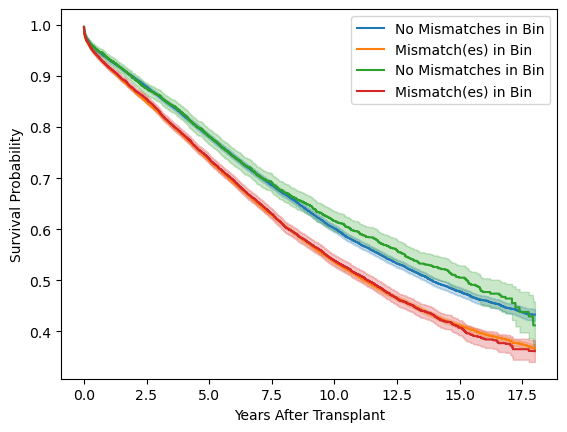

In [46]:
run_validation(8)

Cross Validation 10
CV 9 Runtime 0:24:00.352102
Bin of Amino Acid Positions:
['DRB113', 'C40', 'DRB137', 'DQB110', 'DRB190', 'DRB126', 'C34', 'C145', 'C175', 'B62', 'DQB120']
---
Number of Instances with No Mismatches in Bin:
35893
Number of Instances with Mismatch(es) in Bin:
114024
---
p-value from Log Rank Test:
2.625838312161877e-79


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
         355.55 <0.005    261.04

Bin of Amino Acid Positions:
['DRB113', 'C40', 'DRB137', 'DQB110', 'DRB190', 'DRB126', 'C34', 'C145', 'C175', 'B62', 'DQB120']
---
Number of Instances with No Mismatches in Bin:
3989
Number of Instances with Mismatch(es) in Bin:
12668
---
p-value from Log Rank Test:
1.4863401406784137e-13


<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic      p  -log2(p)
          54.59 <0.005     42.61

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.60034, step_size = 0.9500, log_lik = -601582.22434, newton_decrement = 5761.32105, seconds_since_start = 1.0
Iteration 2: norm_delta = 0.19984, step_size = 0.9500, log_lik = -596039.02644, newton_decrement = 129.98382, seconds_since_start = 1.9
Iteration 3: norm_delta = 0.02064, step_size = 0.9500, log_lik = -595906.60116, newton_decrement = 1.08865, seconds_since_start = 2.8
Iteration 4: norm_delta = 0.00013, step_size = 1.0000, log_lik = -595905.50796, newton_decrement = 0.00005, seconds_since_start = 3.8
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -595905.50791, newton_decrement = 0.00000, seconds_since_start = 4.8
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 149917 total observations, 96391 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 149917
number of events observed = 53526
   partial log-likelihood = -595905.51
         time fit was run = 2023-03-22 07:13:45 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX          0.01       1.01       0.01            -0.00             0.03                 1.00                 1.03
yearslice             -0.05       0.95       0.00            -0.06            -0.05                 0.95                 0.95
diab_noted            -0.17       0.84       0.10            -0.38             0.03                 0.68                 1.03
DCD                    0.08       1.09       0.02             0.05             0.11                 1.06                 1.12
ln_don_wgt_kg_0c      -0.50       0.60       0.07            -0.63            -0.37                 0.53                 0.69
ln_don_wgt_kg_0c_s55   0.48       1.61       0.08             0.33             0.62                 1.39                 1.87
dcadcodanox            0.04       1.05       0.01             0.02             0.07                 1.02                 1.07
dcadcodcva             0.07       1.07       0.01             0.05             0.09                 1.05                 1.10
dcadcodcnst            0.00       1.00       0.05            -0.10             0.11                 0.90                 1.12
dcadcodoth             0.06       1.06       0.03             0.00             0.12                 1.00                 1.12
don_ecd                0.27       1.31       0.06             0.16             0.38                 1.17                 1.46
don_htn_0c             0.14       1.15       0.01             0.12             0.16                 1.13                 1.18
mmA0                  -0.05       0.95       0.02            -0.08            -0.01                 0.92                 0.99
mmA1                   0.00       1.00       0.01            -0.02             0.02                 0.98                 1.02
mmB0                  -0.09       0.91       0.02            -0.14            -0.05                 0.87                 0.95
mmB1                  -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
mmDR0                 -0.05       0.95       0.02            -0.09            -0.01                 0.91                 0.99
mmDR1                 -0.05       0.95       0.01            -0.07            -0.03                 0.93                 0.97
mm0                    0.01       1.01       0.03            -0.05             0.06                 0.95                 1.06
mmC0                  -0.00       1.00       0.03            -0.06             0.05                 0.94                 1.06
mmC1                   0.04       1.04       0.01             0.01             0.06                 1.01                 1.06
mmDQ0                 -0.02       0.98       0.01            -0.05             0.01                 0.95                 1.01
mmDQ1                 -0.02       0.98       0.01            -0.04             0.00                 0.96                 1.00
shared                 0.11       1.11       0.01             0.09             0.13                 1.09                 1.14
PKPRA_1080             0.05       1.05       0.01             0.03             0.07                 1.03                 1.08
PKPRA_GE80             0.19       1.21       0.01             0.16             0.22            

/var/folders/p0/smypln156vjfpjvdmm61f9f00000gv/T/ipykernel_17913/1916850188.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  coxmodeldata[cat_columns] = coxmodeldata[cat_columns].apply(lambda x: pd.factorize(x)[0])


Iteration 1: norm_delta = 0.50718, step_size = 0.9500, log_lik = -53843.34557, newton_decrement = 650.81650, seconds_since_start = 0.2
Iteration 2: norm_delta = 0.18094, step_size = 0.9500, log_lik = -53221.99329, newton_decrement = 18.66476, seconds_since_start = 0.5
Iteration 3: norm_delta = 0.02617, step_size = 0.9500, log_lik = -53202.81102, newton_decrement = 0.21955, seconds_since_start = 0.8
Iteration 4: norm_delta = 0.00028, step_size = 1.0000, log_lik = -53202.59006, newton_decrement = 0.00002, seconds_since_start = 1.0
Iteration 5: norm_delta = 0.00000, step_size = 1.0000, log_lik = -53202.59003, newton_decrement = 0.00000, seconds_since_start = 1.3
Convergence success after 5 iterations.


<lifelines.CoxPHFitter: fitted with 16657 total observations, 10704 right-censored observations>
             duration col = 'graftyrs'
                event col = 'grf_fail'
      baseline estimation = breslow
   number of observations = 16657
number of events observed = 5953
   partial log-likelihood = -53202.59
         time fit was run = 2023-03-22 07:13:51 UTC

---
                       coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                    
DON_AGE                0.01       1.01       0.00             0.01             0.01                 1.01                 1.01
REC_AGE_AT_TX         -0.01       0.99       0.01            -0.04             0.01                 0.96                 1.01
yearslice             -0.05       0.95       0.00            -0.06            -0.04                 0.94                 0.96
diab_noted             0.08       1.08       0.31            -0.53             0.68                 0.59                 1.98
DCD                    0.02       1.02       0.05            -0.07             0.11                 0.93                 1.12
ln_don_wgt_kg_0c      -0.18       0.83       0.22            -0.61             0.24                 0.55                 1.27
ln_don_wgt_kg_0c_s55   0.15       1.17       0.24            -0.32             0.62                 0.73                 1.86
dcadcodanox            0.04       1.04       0.04            -0.04             0.11                 0.96                 1.12
dcadcodcva             0.04       1.05       0.03            -0.02             0.11                 0.98                 1.12
dcadcodcnst           -0.07       0.93       0.16            -0.37             0.24                 0.69                 1.27
dcadcodoth             0.07       1.07       0.09            -0.10             0.24                 0.90                 1.28
don_ecd                0.20       1.22       0.17            -0.14             0.53                 0.87                 1.70
don_htn_0c             0.14       1.15       0.03             0.07             0.20                 1.07                 1.23
mmA0                  -0.15       0.86       0.05            -0.25            -0.04                 0.78                 0.96
mmA1                  -0.01       0.99       0.03            -0.07             0.04                 0.93                 1.04
mmB0                  -0.12       0.89       0.07            -0.26             0.01                 0.77                 1.01
mmB1                  -0.06       0.94       0.03            -0.12             0.00                 0.89                 1.00
mmDR0                 -0.11       0.90       0.06            -0.23             0.02                 0.79                 1.02
mmDR1                 -0.04       0.96       0.03            -0.10             0.02                 0.91                 1.02
mm0                    0.00       1.00       0.09            -0.17             0.18                 0.85                 1.19
mmC0                  -0.08       0.92       0.09            -0.27             0.10                 0.77                 1.11
mmC1                   0.01       1.01       0.04            -0.06             0.08                 0.95                 1.09
mmDQ0                 -0.03       0.97       0.04            -0.11             0.06                 0.90                 1.06
mmDQ1                 -0.04       0.96       0.03            -0.10             0.01                 0.90                 1.01
shared                 0.15       1.17       0.03             0.09             0.22                 1.09                 1.24
PKPRA_1080             0.01       1.01       0.03            -0.05             0.07                 0.95                 1.08
PKPRA_GE80             0.17       1.18       0.05             0.08             0.25                

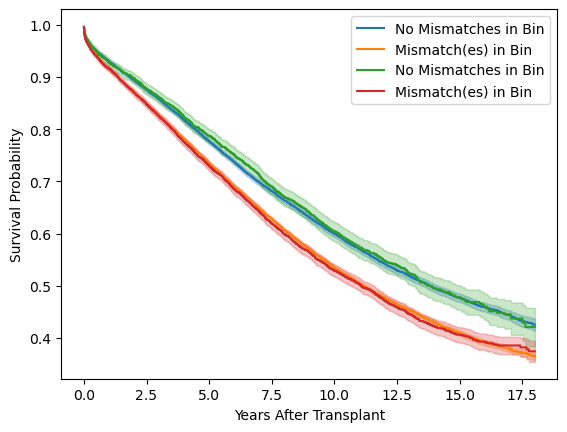

In [47]:
run_validation(9)